# Bloomberg data EDA

## Config

In [1]:
MIN_HIGH_REVENUE = 0  # mln USD
BANKRUPTCY_DATA_VERSION = "4"
CONTROL_DATA_VERSION = None  # None = does not include Control Data

# WARNING: if Control Data is included, it should be consistent with the minimum revenue threshold

## Setup

In [2]:
import datetime as dt
import itertools
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from loguru import logger
from pandas.api.types import is_string_dtype, is_numeric_dtype
from scipy.stats import norm

import shap
from lightgbm import LGBMRegressor, LGBMClassifier
from mlutil.eval import TimeSeriesSplit
from mlutil.model import GAM
# from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoLars
from sklearn.metrics import (
    log_loss, accuracy_score, 
    balanced_accuracy_score, roc_auc_score, f1_score, precision_score, recall_score,
    confusion_matrix, precision_recall_curve, RocCurveDisplay,
    get_scorer_names
)
from sklearn.model_selection import KFold, GridSearchCV, train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

np.random.seed(42**3)

In [3]:
logger.remove()
logger.add(sys.stderr, format='{time} {level} {line}: {message}', level='DEBUG')

plt.style.use('seaborn-v0_8')
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['font.family'] = 'monospace'

np.set_printoptions(edgeitems=30, linewidth=10000)
pd.options.display.max_rows = 200
pd.options.display.max_columns = 80
pd.options.display.max_colwidth = 100

In [4]:
def dht(df, n=2):
    display(pd.concat([df.head(n), df.tail(n)]))

In [5]:
def q25(x):
    return np.nanquantile(x, q=0.25)


def q75(x):
    return np.nanquantile(x, q=0.75)

## Data cleaning

### Load data

In [6]:
# --- All bankrupcy data
b_sheets = pd.read_excel(
    f"data/Bankruptcy Data v{BANKRUPTCY_DATA_VERSION}.xlsx", sheet_name=None, header=0, skiprows=1
)
b_sheet_names = list(b_sheets.keys())
print(b_sheet_names)

assert b_sheet_names[0] == "1. Date and Industry"

# Set a quarter (Q1 starts at January 1)
print("\n- compute Bankruptcy Quarter (Q1 starts at January 1)")
_df = b_sheets["1. Date and Industry"]
_df["Bankruptcy Date"] = pd.to_datetime(_df["Bankruptcy Date"], format=r"%m/%d/%Y")
_df["Bankruptcy Quarter"] = (
    _df["Bankruptcy Date"].dt.year.astype(str) 
    + "Q" + ((_df["Bankruptcy Date"].dt.month - 1) // 3 + 1).astype(str)
)
dht(_df)

['1. Date and Industry', 'Revenue', 'EBITDA', 'EBIT', 'Interest Expense', 'Net Income', 'Total Assets', 'ST Debt', 'LT Debt', 'Equity', 'Inventories', 'Acc Receivable', 'Acc Payable', 'Cash']

- compute Bankruptcy Quarter (Q1 starts at January 1)


,Name,Bankruptcy Date,Industry (Detailed),Assets (As of Bankruptcy date),Liabilities (As of Bankruptcy date),Ticker,BBID,Industry Level 1,BISC Code lvl1,Bankruptcy Quarter
0,VITAL PHARMACEUTICALS INC,2022-10-10,Sports & Energy Drinks,NaN,NaN,0311510Z US Equity,17394873,Consumer Staples,12,2022Q4
1,KABBAGE INC,2022-10-03,Commercial Finance,NaN,NaN,8172566Z US Equity,23987674,Financials,14,2022Q4
3059,BRADLEES INC,1995-06-23,Discount Stores,914.93M,783.56M,BLEEQ US Equity,100221,Consumer Staples,12,1995Q2
3060,MCCLATCHY CO LLC/THE,1900-07-01,Newspaper Publishers,946.50M,01.68B,1828306D US Equity,68830710,Communications,10,1900Q3


In [7]:
# --- Aux function to fix control quarter columns
def fix_control_quarters_columns(df: pd.DataFrame) -> None:
    old_qcols = [x for x in df.columns if (len(x.split(":")) == 3) and (x[-2] == "Q")]
    new_qcols = [x[-2:] + " " + x[-5:-3] for x in old_qcols]
    assert all(len(x) == 5 for x in new_qcols)
    df.rename(columns=dict(zip(old_qcols, new_qcols)), inplace=True)
    for col in new_qcols:
        df[col] /= 1000000
    

_df = pd.DataFrame({
    "Ticker": ["ADD", "BDD"], 
    "Q3 21": [0, 1.3], 
    "Revenue:2021:Q4": [1200000, 1340000],
})
_df_expected = pd.DataFrame({
    "Ticker": ["ADD", "BDD"], 
    "Q3 21": [0, 1.3], 
    "Q4 21": [1.2, 1.34],
})
fix_control_quarters_columns(_df)
pd.testing.assert_frame_equal(_df, _df_expected)

In [8]:
# --- Clean control data (make consistent with bankruptcy data) ---

if CONTROL_DATA_VERSION is not None:
    c_sheets = pd.read_excel(
        f"data/Control Data v{CONTROL_DATA_VERSION}.xlsx", 
        sheet_name=None, 
        header=0, 
        skiprows=[0, 1, 3],
    )
    c_sheet_names = list(c_sheets.keys())
    print(c_sheet_names)
    
    # Rename sheets
    c_sheets["1. Date and Industry"] = c_sheets.pop("1. Industry")
    c_sheet_names = list(c_sheets.keys())
    print(c_sheet_names)
    assert set(c_sheet_names) == set(b_sheet_names)

    # Fix master df 
    _df = c_sheets["1. Date and Industry"]
    _df.rename(columns={
        "Short Name": "Name",
        "BICS L1 Sect Nm": "Industry Level 1",
        "BICS L1 Sect Cde": "BISC Code lvl1",
    }, inplace=True)
    # _df["Bankruptcy Date"] = "01/01/2050"

    # Fix metrics dfs
    assert c_sheet_names[-1] == "1. Date and Industry"
    for sname in c_sheet_names[:-1]:
        _df = c_sheets[sname]
        _df.rename(columns={"Short Name": "Name"}, inplace=True)
        fix_control_quarters_columns(_df)
        assert all(x.startswith("Q") for x in _df.columns[2:])
        for c in _df.columns[2:]:
            if not is_numeric_dtype(_df[c].dtype):
                print(f"WARNING: {sname} {c} has type {_df[c].dtype}")
                _df[c] = pd.to_numeric(_df[c], errors="coerce")
                
    # Concatenate bankruptcy and controlled data
    sheets = {}
    for sname in b_sheet_names:
        print(f"concatenate {sname}: {len(b_sheets[sname])} + {len(c_sheets[sname])}")
        sheets[sname] = pd.concat((b_sheets[sname], c_sheets[sname]), ignore_index=True)
        
else:
    sheets = b_sheets
    
sheet_names = b_sheet_names
dht(sheets["1. Date and Industry"])
dht(sheets["Revenue"])
dht(sheets["Cash"])

for sname in sheet_names[1:]:
    _df = sheets[sname]
    assert all(x.startswith("Q") for x in _df.columns[3:])
    for c in _df.columns[3:]:
        if not is_numeric_dtype(_df[c].dtype):
            raise TypeError(f"{sname} {c} has type {_df[c].dtype}")

,Name,Bankruptcy Date,Industry (Detailed),Assets (As of Bankruptcy date),Liabilities (As of Bankruptcy date),Ticker,BBID,Industry Level 1,BISC Code lvl1,Bankruptcy Quarter
0,VITAL PHARMACEUTICALS INC,2022-10-10,Sports & Energy Drinks,NaN,NaN,0311510Z US Equity,17394873,Consumer Staples,12,2022Q4
1,KABBAGE INC,2022-10-03,Commercial Finance,NaN,NaN,8172566Z US Equity,23987674,Financials,14,2022Q4
3059,BRADLEES INC,1995-06-23,Discount Stores,914.93M,783.56M,BLEEQ US Equity,100221,Consumer Staples,12,1995Q2
3060,MCCLATCHY CO LLC/THE,1900-07-01,Newspaper Publishers,946.50M,01.68B,1828306D US Equity,68830710,Communications,10,1900Q3


,Name,Ticker,BCY year,Q4 21,Q3 21,Q2 21,Q1 21,Q4 20,Q3 20,Q2 20,Q1 20,Q4 19,Q3 19,Q2 19,Q1 19,Q4 18,Q3 18,Q2 18,Q1 18,Q4 17,Q3 17,Q2 17,Q1 17,Q4 16,Q3 16,Q2 16,Q1 16,Q4 15,Q3 15,Q2 15,Q1 15,Q4 14,Q3 14,Q2 14,Q1 14,Q4 13,Q3 13,Q2 13,Q1 13,Q4 12,...,Q4 07,Q3 07,Q2 07,Q1 07,Q4 06,Q3 06,Q2 06,Q1 06,Q4 05,Q3 05,Q2 05,Q1 05,Q4 04,Q3 04,Q2 04,Q1 04,Q4 03,Q3 03,Q2 03,Q1 03,Q4 02,Q3 02,Q2 02,Q1 02,Q4 01,Q3 01,Q2 01,Q1 01,Q4 00,Q3 00,Q2 00,Q1 00,Q4 99,Q3 99,Q2 99,Q1 99,Q4 98,Q3 98,Q2 98,Q1 98
0,CLARUS THERAPEUTICS HOLDINGS,CRXT US Equity,2022,4.562,4.286,0.00,0.000,0.000,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ENDO INTERNATIONAL PLC,ENDPQ US Equity,2022,789.429,772.028,713.83,717.919,760.221,634.86,687.588,820.405,764.8,729.426,699.727,720.411,786.389,745.466,714.696,700.527,768.64,786.887,875.731,1037.6,1241.513,884.335,920.887,963.539,1073.697,745.727,735.166,714.128,662.877,654.116,592.848,470.842,584.946,661.319,712.148,658.494,749.82,...,304.582,269.47,257.147,254.409,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
765,IMPERIAL HOLLY CORP,IHKS US Equity,2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,372.273987,372.585999,428.462006,457.153992,466.312988,429.165009,468.598999,487.894989,499.976990,428.997009,471.760986,477.170013,456.087006,414.96701,434.867004
766,AMERICAN HOMESTAR CORP,HSTRQ US Equity,2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.322998,139.113007,130.354996,138.789001,165.779007,144.132996,151.399994,169.022003,147.531006,130.727997,117.319000,125.01400,124.732002


,Name,Ticker,BCY year,Q4 21,Q3 21,Q2 21,Q1 21,Q4 20,Q3 20,Q2 20,Q1 20,Q4 19,Q3 19,Q2 19,Q1 19,Q4 18,Q3 18,Q2 18,Q1 18,Q4 17,Q3 17,Q2 17,Q1 17,Q4 16,Q3 16,Q2 16,Q1 16,Q4 15,Q3 15,Q2 15,Q1 15,Q4 14,Q3 14,Q2 14,Q1 14,Q4 13,Q3 13,Q2 13,Q1 13,Q4 12,...,Q4 07,Q3 07,Q2 07,Q1 07,Q4 06,Q3 06,Q2 06,Q1 06,Q4 05,Q3 05,Q2 05,Q1 05,Q4 04,Q3 04,Q2 04,Q1 04,Q4 03,Q3 03,Q2 03,Q1 03,Q4 02,Q3 02,Q2 02,Q1 02,Q4 01,Q3 01,Q2 01,Q1 01,Q4 00,Q3 00,Q2 00,Q1 00,Q4 99,Q3 99,Q2 99,Q1 99,Q4 98,Q3 98,Q2 98,Q1 98
0,CLARUS THERAPEUTICS HOLDINGS,CRXT US Equity,2022,26.415,21.953,0.224535,0.408195,0.655371,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ENDO INTERNATIONAL PLC,ENDPQ US Equity,2022,1507.196,1568.665,1545.172000,1427.775000,1213.437000,1679.738,1780.087,1531.538,1454.531,1526.25,1446.949,981.739,1149.113,1118.885,1098.788,980.412,986.605,738.393,616.534,617.589,517.25,561.577,667.822,221.968,272.348,836.111,2529.735,377.461,405.696,708.529,1427.244,1041.28,526.597,594.085,505.608,340.517,529.689,...,350.325,274.884,445.829,730.857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3059,BRADLEES INC,BLEEQ US Equity,100221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3060,MCCLATCHY CO LLC/THE,1828306D US Equity,68830710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Company, Name, Ticker, Industry, Bankruptcy date

In [9]:
def unify_bloombergs_units(ss: pd.Series) -> pd.Series:
    assert is_string_dtype(ss.dtype)
    numbers = ss.str[:-1].astype(float)
    units = ss.str[-1:]
    unified_numbers = numbers * units.map({"M": 1., "B": 1000., "k": 0.001}).astype(float)
    return unified_numbers


def keep_us_only(df: pd.DataFrame) -> pd.DataFrame:
    return df.loc[df["Ticker"].str.endswith(" US Equity")].reset_index(drop=True)


def shorten_ticker(tickers: pd.Series) -> pd.Series:
    assert tickers.str.endswith(" Equity").all()
    short_tickers = tickers.str.split(n=1).str[0]
    assert short_tickers.nunique() == tickers.nunique()
    return short_tickers


def encode_quarter(quarters: pd.Series) -> pd.Series:
    assert is_string_dtype(quarters.dtype)
    assert (quarters.isnull() | (quarters.str.len() == 6)).all()
    years = quarters.str[:4].astype(pd.Int64Dtype())
    assert (1970 <= years).all() 
    assert (2050 >= years).all() 
    qs = quarters.str[5].astype(pd.Int64Dtype())
    qs.isin(set([1, 2, 3, 4])) 
    qcodes = years * 4 + (qs - 1)
    assert qcodes.nunique() == quarters.nunique()
    return qcodes


def decode_quarter(qcodes: pd.Series) -> pd.Series:
    assert (7800 < qcodes).all()
    assert (8200 > qcodes).all()
    years = qcodes // 4
    qs = qcodes % 4 + 1
    quarters = years.astype(str) + "Q" + qs.astype(str)
    assert qcodes.nunique() == quarters.nunique()
    return quarters

In [10]:
pd.testing.assert_series_equal(
    unify_bloombergs_units(pd.Series(["13.4M", "1.4B", "90.3k"])),
    pd.Series([13.4, 1400., 0.0903])
)

pd.testing.assert_series_equal(
    shorten_ticker(pd.Series(["0311510Z US Equity", "BLEEQ CN Equity"])),
    pd.Series(["0311510Z", "BLEEQ"])
)

pd.testing.assert_series_equal(
    encode_quarter(pd.Series(["2020Q1", "2021Q1", "2021Q2"])),
    pd.Series([8080, 8084, 8085], dtype=pd.Int64Dtype())
)

pd.testing.assert_series_equal(
    encode_quarter(pd.Series(["2020Q1", "2021Q1", pd.NA])),
    pd.Series([8080, 8084, pd.NA], dtype=pd.Int64Dtype())
)

pd.testing.assert_series_equal(
    decode_quarter(pd.Series([8080, 8084, 8085])),
    pd.Series(["2020Q1", "2021Q1", "2021Q2"])
)

In [11]:
# --- Clean the master sheet (Ticker + Industry + Bankruptcy data)

_df = sheets["1. Date and Industry"]
dht(_df)
print(f"n records = {len(_df)}")

# Remove non-US companies
print("\n- keep US companies only")
_df = keep_us_only(_df)
print(f"n records = {len(_df)}")

# Short ticker name
print("\n- create Short Ticker")
_df["Short Ticker"] = shorten_ticker(_df["Ticker"])

# Uniform format for Assets and Liabilities
print("\n- convert assets and liabilities to M USD")
print(_df["Assets (As of Bankruptcy date)"].str[-1:].value_counts(dropna=False))
print(_df["Liabilities (As of Bankruptcy date)"].str[-1:].value_counts(dropna=False))
_df["Assets (As of Bankruptcy date)"] = unify_bloombergs_units(_df["Assets (As of Bankruptcy date)"])
_df["Liabilities (As of Bankruptcy date)"] = unify_bloombergs_units(_df["Liabilities (As of Bankruptcy date)"])

master_df = _df
dht(master_df)

,Name,Bankruptcy Date,Industry (Detailed),Assets (As of Bankruptcy date),Liabilities (As of Bankruptcy date),Ticker,BBID,Industry Level 1,BISC Code lvl1,Bankruptcy Quarter
0,VITAL PHARMACEUTICALS INC,2022-10-10,Sports & Energy Drinks,NaN,NaN,0311510Z US Equity,17394873,Consumer Staples,12,2022Q4
1,KABBAGE INC,2022-10-03,Commercial Finance,NaN,NaN,8172566Z US Equity,23987674,Financials,14,2022Q4
3059,BRADLEES INC,1995-06-23,Discount Stores,914.93M,783.56M,BLEEQ US Equity,100221,Consumer Staples,12,1995Q2
3060,MCCLATCHY CO LLC/THE,1900-07-01,Newspaper Publishers,946.50M,01.68B,1828306D US Equity,68830710,Communications,10,1900Q3


n records = 3061

- keep US companies only
n records = 2983

- create Short Ticker

- convert assets and liabilities to M USD
M      1999
NaN     480
B       391
k       113
Name: Assets (As of Bankruptcy date), dtype: int64
M      2219
B       488
NaN     266
k        10
Name: Liabilities (As of Bankruptcy date), dtype: int64


,Name,Bankruptcy Date,Industry (Detailed),Assets (As of Bankruptcy date),Liabilities (As of Bankruptcy date),Ticker,BBID,Industry Level 1,BISC Code lvl1,Bankruptcy Quarter,Short Ticker
0,VITAL PHARMACEUTICALS INC,2022-10-10,Sports & Energy Drinks,NaN,NaN,0311510Z US Equity,17394873,Consumer Staples,12,2022Q4,0311510Z
1,KABBAGE INC,2022-10-03,Commercial Finance,NaN,NaN,8172566Z US Equity,23987674,Financials,14,2022Q4,8172566Z
2981,BRADLEES INC,1995-06-23,Discount Stores,914.93,783.56,BLEEQ US Equity,100221,Consumer Staples,12,1995Q2,BLEEQ
2982,MCCLATCHY CO LLC/THE,1900-07-01,Newspaper Publishers,946.50,1680.00,1828306D US Equity,68830710,Communications,10,1900Q3,1828306D


In [12]:
# Industries
master_df["Industry Level 1"].value_counts()

Consumer Discretionary    717
Industrials               383
Energy                    290
Communications            258
Health Care               242
Real Estate               241
Financials                234
Materials                 209
Technology                170
Consumer Staples          166
Utilities                  60
Unclassifiable              1
Government                  1
Name: Industry Level 1, dtype: int64

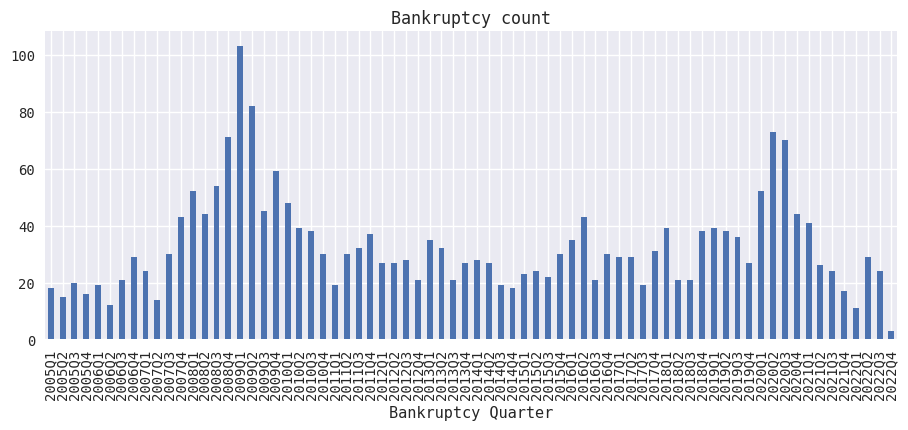

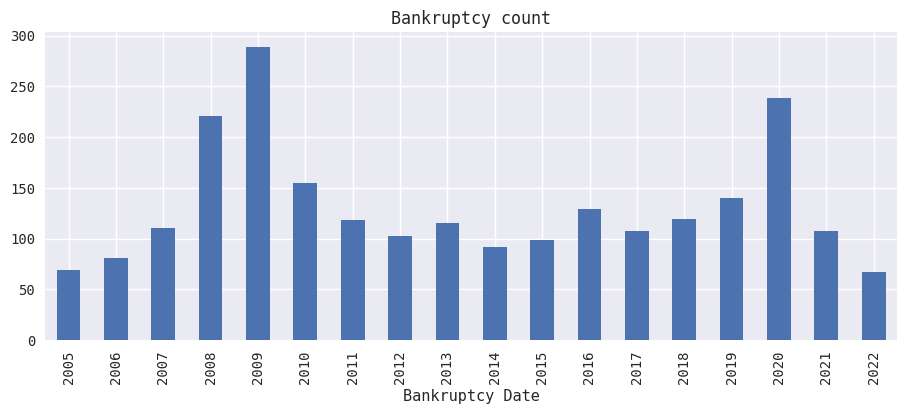

In [13]:
# --- Plot bankruptcy counts ---

plt.figure()
(
    master_df.loc[master_df["Bankruptcy Quarter"] >= "2005"]
    .groupby("Bankruptcy Quarter")["Bankruptcy Quarter"].count()
    .plot(kind="bar", figsize=(11, 4), title="Bankruptcy count")
)
plt.figure()
(
    master_df.loc[master_df["Bankruptcy Quarter"] >= "2005"]
    .groupby(master_df["Bankruptcy Date"].dt.year)["Bankruptcy Date"].count()
    .plot(kind="bar", figsize=(11, 4), title="Bankruptcy count")
)
_ = _

In [14]:
# --- Example of a duplicate (two bunkruptcies of one company)
master_df.loc[master_df["Ticker"] == "HCR US Equity"]

,Name,Bankruptcy Date,Industry (Detailed),Assets (As of Bankruptcy date),Liabilities (As of Bankruptcy date),Ticker,BBID,Industry Level 1,BISC Code lvl1,Bankruptcy Quarter,Short Ticker
281,HI-CRUSH INC,2020-07-12,Oilfield Services & Equipment,953.08,699.14,HCR US Equity,32051410,Energy,13,2020Q3,HCR
652,MANOR CARE INC,2018-03-04,Oilfield Services & Equipment,4260.00,7120.00,HCR US Equity,100719,Energy,13,2018Q1,HCR


In [15]:
# --- Remove companies with multiple bankrupcies (for simplicity) ---

print(f'duplicates: {master_df["Ticker"].duplicated(keep=False).sum()} / {len(master_df)}')
print(f'duplicates: {master_df["Short Ticker"].duplicated(keep=False).sum()} / {len(master_df)}')

print("\ndrop tickers with duplicates")
all_valid_tickers = set(master_df["Short Ticker"].drop_duplicates(keep=False))
print(f"n tickers = {len(all_valid_tickers)}")

duplicates: 100 / 2983
duplicates: 100 / 2983

drop tickers with duplicates
n tickers = 2883


### Filter tickets by revenue

count      730.000000
mean       459.452965
std       2126.440886
min          0.000000
25%         18.261900
50%         84.662514
75%        270.119668
max      42989.444444
Name: Mean Revenue, dtype: float64


,Name,Ticker,BCY year,Q4 21,Q3 21,Q2 21,Q1 21,Q4 20,Q3 20,Q2 20,Q1 20,Q4 19,Q3 19,Q2 19,Q1 19,Q4 18,Q3 18,Q2 18,Q1 18,Q4 17,Q3 17,Q2 17,Q1 17,Q4 16,Q3 16,Q2 16,Q1 16,Q4 15,Q3 15,Q2 15,Q1 15,Q4 14,Q3 14,Q2 14,Q1 14,Q4 13,Q3 13,Q2 13,Q1 13,Q4 12,...,Q2 07,Q1 07,Q4 06,Q3 06,Q2 06,Q1 06,Q4 05,Q3 05,Q2 05,Q1 05,Q4 04,Q3 04,Q2 04,Q1 04,Q4 03,Q3 03,Q2 03,Q1 03,Q4 02,Q3 02,Q2 02,Q1 02,Q4 01,Q3 01,Q2 01,Q1 01,Q4 00,Q3 00,Q2 00,Q1 00,Q4 99,Q3 99,Q2 99,Q1 99,Q4 98,Q3 98,Q2 98,Q1 98,Short Ticker,Mean Revenue
539,OCEAN POWER CORP,PWREQ US Equity,2002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PWREQ,0.000000
345,FORTICELL BIOSCIENCE INC,FORBQ US Equity,2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FORBQ,0.000000
546,SYNERGY TECHNOLOGIES CORP,OILS US Equity,2002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OILS,0.000000
371,1PM INDUSTRIES INC,OPMZ US Equity,2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OPMZ,0.000000
102,GASTAR EXPLORATION LTD,GSTC US Equity,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000648,0.000242,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.005901,0.008454,0.006623,0.013133,0.003236,0.019161,0.015119,0.028064,0.021859,0.03221,0.016739,0.002915,0.01375,0.023957,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GSTC,0.007067


,Name,Ticker,BCY year,Q4 21,Q3 21,Q2 21,Q1 21,Q4 20,Q3 20,Q2 20,Q1 20,Q4 19,Q3 19,Q2 19,Q1 19,Q4 18,Q3 18,Q2 18,Q1 18,Q4 17,Q3 17,Q2 17,Q1 17,Q4 16,Q3 16,Q2 16,Q1 16,Q4 15,Q3 15,Q2 15,Q1 15,Q4 14,Q3 14,Q2 14,Q1 14,Q4 13,Q3 13,Q2 13,Q1 13,Q4 12,...,Q2 07,Q1 07,Q4 06,Q3 06,Q2 06,Q1 06,Q4 05,Q3 05,Q2 05,Q1 05,Q4 04,Q3 04,Q2 04,Q1 04,Q4 03,Q3 03,Q2 03,Q1 03,Q4 02,Q3 02,Q2 02,Q1 02,Q4 01,Q3 01,Q2 01,Q1 01,Q4 00,Q3 00,Q2 00,Q1 00,Q4 99,Q3 99,Q2 99,Q1 99,Q4 98,Q3 98,Q2 98,Q1 98,Short Ticker,Mean Revenue
357,WASHINGTON MUTUAL INC,WAMUQ US Equity,2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6506.0,6549.0,6802.0,6675.0,6513.0,6248.0,5962.0,5314.0,4973.0,4768.0,4283.0,4222.0,3647.0,4047.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WAMUQ,5550.444444
237,AMR CORP,AAMRQ US Equity,2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5879.0,5427.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAMRQ,5638.400000
422,DPH HOLDINGS CORP,DPHIQ US Equity,2005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,6779.0,6283.0,7023.0,6862.0,7033.0,6642.0,7549.0,7411.0,7251.0,6558.0,7091.0,7182.0,6971.0,6446.0,7322.0,6688.0,6380.0,6229.0,6944.0,6535.0,6909.0,6648.0,7778.0,7804.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DPHIQ,6929.916667
574,WORLDCOM INC-WORLDCOM GROUP,WCOEQ US Equity,2002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5078.0,5301.0,5482.0,5362.0,5203.0,9634.0,10037.0,9807.0,9612.0,9989.0,8996.0,9065.0,9122.0,9510.0,3758.0,2581.0,2320.0,WCOEQ,7109.235294
621,KMART CORP/OLD,KMRTQ US Equity,2002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10878.0,8019.0,8917.0,8337.0,11636.0,8199.0,8998.0,8195.0,11104.0,7962.0,8780.0,8078.0,10401.0,7642.0,8116.0,7515.0,9759.0,7315.0,7846.0,7263.0,KMRTQ,8748.000000
104,SEARS HOLDINGS CORP,SHLDQ US Equity,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4376.0,3575.0,4365.0,4199.0,6052.0,5029.0,5663.0,5394.0,7303.0,5750.0,6211.0,5882.0,8099.0,7207.0,8013.0,7879.0,10593.000,8272.000,8871.000,8452.00,12260.000,8857.000,9467.000,9270.000,12484.000,...,12785.0,11998.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SHLDQ,9384.666667
358,LEHMAN BROTHERS HOLDINGS INC,LEHMQ US Equity,2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15579.0,13795.0,13160.0,11727.0,11515.0,10307.0,9055.0,8639.0,7335.0,7391.0,5846.0,5051.0,5228.0,5125.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LEHMQ,9490.368421
192,INVERSIONES ALSACIA SA,1087117D US Equity,2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24921.042,24182.305,23727.873,20536.54,22828.299,20193.253,19738.206,18692.258,21962.926,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1087117D,21031.016083
635,ENRON CORP,ENE US Equity,2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

Name            FRANKLIN CREDIT HOLDING CORP
Ticker                       FCMCQ US Equity
BCY year                                2012
Q1 12                               2.757013
Q4 11                               3.203024
Q3 11                               3.385199
Q2 11                              52.817992
Q1 11                              34.981141
Q4 10                               5.981583
Q3 10                               4.117724
Q2 10                              12.135293
Q1 10                              19.512042
Q4 09                              14.597854
Q3 09                              20.982985
Q2 09                              14.629757
Q1 09                             -325.51524
Q4 08                              19.716973
Q3 08                              24.119235
Q2 08                              30.878048
Q1 08                              35.215012
Q4 07                              38.025393
Q3 07                              41.563546
Q2 07     

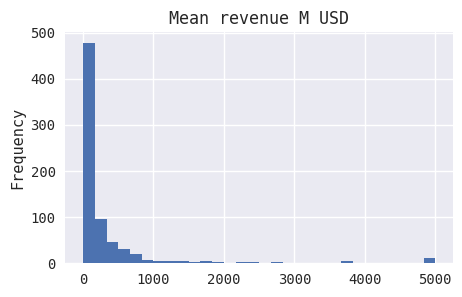

In [16]:
# --- Check revenues ---

_df = sheets["Revenue"].copy()
_df = keep_us_only(_df)
_df["Short Ticker"] = shorten_ticker(_df["Ticker"])
_df = _df.loc[_df["Short Ticker"].isin(all_valid_tickers)].reset_index(drop=True)
assert _df["Short Ticker"].duplicated().sum() == 0
_df["Mean Revenue"] = _df.filter(regex="^Q\d \d\d").mean(axis=1)
print(_df["Mean Revenue"].describe())
display(_df.sort_values("Mean Revenue").head(5))
display(_df.sort_values("Mean Revenue").tail(10))
_df["Mean Revenue"].clip(upper=5000).plot(
    kind="hist", bins=30, figsize=(5, 3), title="Mean revenue M USD"
)
display(_df.loc[_df["Ticker"] == "FCMCQ US Equity"].iloc[0].dropna())
_ = _

In [17]:
def filter_tickers(
    revenue_sheet, tickers, minimum_high_revenue: float = 0, drop_zero_revenue: bool = False
):
    _df = revenue_sheet.copy()
    print(f"n records = {len(_df)}")
    
    # Keep US only
    _df = keep_us_only(_df)
    print(f"n records = {len(_df)}")
    
    # Keep big companies only
    # WARNING: future-looking!
    print(f"- only keep companies with highest revenue > {minimum_high_revenue}M USD")
    _df = _df.loc[_df.iloc[:, 3:].max(axis=1) > minimum_high_revenue].reset_index(drop=True)
    print(f"n records = {len(_df)}")

    # Keep positive revenue only
    if drop_zero_revenue:
        print(f"- only keep companies non-zero revenues")
        _df = _df.loc[~(_df.iloc[:, 3:].abs() < 0.0001).any(axis=1)].reset_index(drop=True)
    print(f"n records = {len(_df)}")
    
    # Short ticker name
    print(f"- intersect revenue and master tickers")
    _df.insert(3, "Short Ticker", shorten_ticker(_df["Ticker"]))
    print("duplicated short tickers:", _df["Short Ticker"].duplicated().sum())

    # Tickers of interest
    new_tickers = tickers & set(_df["Short Ticker"])
    print(f"n tickers of interests = {len(new_tickers)} / {len(tickers)}")
    
    return new_tickers

In [18]:
# --- Filter out tickers with low revenues ---

dht(sheets["Revenue"])
tickers = filter_tickers(
    sheets["Revenue"], all_valid_tickers, minimum_high_revenue=MIN_HIGH_REVENUE, drop_zero_revenue=True
)
print(len(tickers), list(tickers)[:10], "...")

,Name,Ticker,BCY year,Q4 21,Q3 21,Q2 21,Q1 21,Q4 20,Q3 20,Q2 20,Q1 20,Q4 19,Q3 19,Q2 19,Q1 19,Q4 18,Q3 18,Q2 18,Q1 18,Q4 17,Q3 17,Q2 17,Q1 17,Q4 16,Q3 16,Q2 16,Q1 16,Q4 15,Q3 15,Q2 15,Q1 15,Q4 14,Q3 14,Q2 14,Q1 14,Q4 13,Q3 13,Q2 13,Q1 13,Q4 12,...,Q4 07,Q3 07,Q2 07,Q1 07,Q4 06,Q3 06,Q2 06,Q1 06,Q4 05,Q3 05,Q2 05,Q1 05,Q4 04,Q3 04,Q2 04,Q1 04,Q4 03,Q3 03,Q2 03,Q1 03,Q4 02,Q3 02,Q2 02,Q1 02,Q4 01,Q3 01,Q2 01,Q1 01,Q4 00,Q3 00,Q2 00,Q1 00,Q4 99,Q3 99,Q2 99,Q1 99,Q4 98,Q3 98,Q2 98,Q1 98
0,CLARUS THERAPEUTICS HOLDINGS,CRXT US Equity,2022,4.562,4.286,0.00,0.000,0.000,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ENDO INTERNATIONAL PLC,ENDPQ US Equity,2022,789.429,772.028,713.83,717.919,760.221,634.86,687.588,820.405,764.8,729.426,699.727,720.411,786.389,745.466,714.696,700.527,768.64,786.887,875.731,1037.6,1241.513,884.335,920.887,963.539,1073.697,745.727,735.166,714.128,662.877,654.116,592.848,470.842,584.946,661.319,712.148,658.494,749.82,...,304.582,269.47,257.147,254.409,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
765,IMPERIAL HOLLY CORP,IHKS US Equity,2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,372.273987,372.585999,428.462006,457.153992,466.312988,429.165009,468.598999,487.894989,499.976990,428.997009,471.760986,477.170013,456.087006,414.96701,434.867004
766,AMERICAN HOMESTAR CORP,HSTRQ US Equity,2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.322998,139.113007,130.354996,138.789001,165.779007,144.132996,151.399994,169.022003,147.531006,130.727997,117.319000,125.01400,124.732002


n records = 767
n records = 745
- only keep companies with highest revenue > 0M USD
n records = 741
- only keep companies non-zero revenues
n records = 677
- intersect revenue and master tickers
duplicated short tickers: 0
n tickers of interests = 664 / 2883
664 ['WPG', 'SARA', 'VENX', 'HARR', 'CTDBQ', 'AMFIQ', 'CSKEQ', 'ACRTQ', 'XOXOQ', 'ARPJ'] ...


### Revenue and other metrics

In [19]:
# --- Overview of all available metrics ---

for s_name in sheet_names[1:]:
    print(f"{s_name} {sheets[s_name].shape} {sheets[s_name].notnull().sum().sum()}")

Revenue (767, 99) 20191
EBITDA (767, 99) 19164
EBIT (3061, 99) 26698
Interest Expense (3061, 99) 23500
Net Income (3061, 99) 26978
Total Assets (3061, 99) 26885
ST Debt (3061, 99) 26573
LT Debt (3061, 99) 26856
Equity (3061, 99) 26738
Inventories (3061, 99) 25633
Acc Receivable (3061, 99) 26570
Acc Payable (3061, 99) 25225
Cash (3061, 99) 26884


In [20]:
# --- Aux function to transform quarter columns

_year_end_mapping = {"2": "20", "1": "20", "0": "20", "9": "19", "8": "19"}


def rename_quarters_columns(df: pd.DataFrame) -> None:
    old_qcols = [x for x in df.columns if (len(x) == 5) and (x[0] == "Q") and (x[2] == " ")]
    new_qcols = [
        _year_end_mapping[x[-2]] + x[-2:] + x[:2] for x in old_qcols
    ]
    assert all(len(x) == 6 for x in new_qcols)
    df.rename(columns=dict(zip(old_qcols, new_qcols)), inplace=True)
    

_df = pd.DataFrame({"Ticker": ["ADD", "BDD"], "Q3 21": [0, 1.3], "Q4 21": [1.2, 1.34]})
_df_expected = pd.DataFrame({"Ticker": ["ADD", "BDD"], "2021Q3": [0, 1.3], "2021Q4": [1.2, 1.34]})
rename_quarters_columns(_df)
pd.testing.assert_frame_equal(_df, _df_expected)

In [21]:
# --- Transform all the metric spreadsheets ---

wide_sheets = {}
narrow_sheets = {}

for s_name in sheet_names[1:]:
    print(f"-- {s_name} --")
    _df = sheets[s_name].copy()
    print(f"n records = {len(_df)}")
    _df = keep_us_only(_df)
    print(f"n records = {len(_df)}")
    print("duplicates: ", _df["Ticker"].duplicated().sum())
    _df = _df.loc[~(_df["BCY year"] > 2050)].reset_index(drop=True)
    print("duplicates (correct BCY): ", _df["Ticker"].duplicated().sum())
    _df.insert(3, "Short Ticker", shorten_ticker(_df["Ticker"]))
    _df = _df.loc[_df["Short Ticker"].isin(tickers)].reset_index(drop=True)
    _df = _df.iloc[:, 3:].set_index("Short Ticker")
    assert _df.index.is_unique
    rename_quarters_columns(_df)
    print(f"{s_name}: {_df.shape} {_df.notnull().sum().sum()}")
    wide_sheets[s_name] = _df
    _df_melted = _df.reset_index().melt(id_vars="Short Ticker", var_name="Quarter", value_name=s_name)
    assert (_df_melted["Quarter"].str.len() == 6).all()
    _df_melted = _df_melted.set_index(["Short Ticker", "Quarter"])
    assert _df_melted.index.is_unique
    narrow_sheets[s_name] = _df_melted[s_name]
    print(f"{s_name} melted: {_df_melted.shape} {_df_melted.notnull().sum().sum()}")
    
dht(_df)
dht(_df_melted)

-- Revenue --
n records = 767
n records = 745
duplicates:  1
duplicates (correct BCY):  1
Revenue: (664, 96) 15459
Revenue melted: (63744, 1) 15459
-- EBITDA --
n records = 767
n records = 745
duplicates:  1
duplicates (correct BCY):  1
EBITDA: (664, 96) 14577
EBITDA melted: (63744, 1) 14577
-- EBIT --
n records = 3061
n records = 2993
duplicates:  647
duplicates (correct BCY):  1
EBIT: (664, 96) 15071
EBIT melted: (63744, 1) 15071
-- Interest Expense --
n records = 3061
n records = 2993
duplicates:  647
duplicates (correct BCY):  1
Interest Expense: (664, 96) 12407
Interest Expense melted: (63744, 1) 12407
-- Net Income --
n records = 3061
n records = 2993
duplicates:  647
duplicates (correct BCY):  1
Net Income: (664, 96) 15370
Net Income melted: (63744, 1) 15370
-- Total Assets --
n records = 3061
n records = 2993
duplicates:  647
duplicates (correct BCY):  1
Total Assets: (664, 96) 15268
Total Assets melted: (63744, 1) 15268
-- ST Debt --
n records = 3061
n records = 2993
duplicate

,2021Q4,2021Q3,2021Q2,2021Q1,2020Q4,2020Q3,2020Q2,2020Q1,2019Q4,2019Q3,2019Q2,2019Q1,2018Q4,2018Q3,2018Q2,2018Q1,2017Q4,2017Q3,2017Q2,2017Q1,2016Q4,2016Q3,2016Q2,2016Q1,2015Q4,2015Q3,2015Q2,2015Q1,2014Q4,2014Q3,2014Q2,2014Q1,2013Q4,2013Q3,2013Q2,2013Q1,2012Q4,2012Q3,2012Q2,2012Q1,...,2007Q4,2007Q3,2007Q2,2007Q1,2006Q4,2006Q3,2006Q2,2006Q1,2005Q4,2005Q3,2005Q2,2005Q1,2004Q4,2004Q3,2004Q2,2004Q1,2003Q4,2003Q3,2003Q2,2003Q1,2002Q4,2002Q3,2002Q2,2002Q1,2001Q4,2001Q3,2001Q2,2001Q1,2000Q4,2000Q3,2000Q2,2000Q1,1999Q4,1999Q3,1999Q2,1999Q1,1998Q4,1998Q3,1998Q2,1998Q1
Short Ticker,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ENDPQ,1507.196,1568.665,1545.172,1427.775,1213.437,1679.738,1780.087,1531.538,1454.531,1526.250,1446.949,981.739,1149.113,1118.885,1098.788,980.412,986.605,738.393,616.534,617.589,517.250,561.577,667.822,221.968,272.348,836.111,2529.735,377.461,405.696,708.529,1427.244,1041.28,526.597,594.085,505.608,340.517,529.689,256.917,391.946,248.303,...,350.325,274.884,445.829,730.857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TOO,190.942,194.570,241.132,197.078,235.734,236.911,241.098,203.725,199.388,270.827,201.567,182.791,225.040,199.860,241.202,225.892,221.934,416.346,212.267,193.419,227.378,222.872,380.718,335.751,258.473,251.058,242.764,278.846,252.138,224.566,251.561,222.99,219.126,258.900,163.744,172.801,206.339,205.753,179.462,234.742,...,121.224,96.589,100.718,114.343,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IHKS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.615,7.076,9.719000,6.533,3.424000,15.850,14.655000,7.925000,10.997000,9.278000,2.436000,2.877000,9.408000,14.079000,17.299000
HSTRQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.773998,42.820,36.761002,34.027,41.174999,51.278999,44.830002,74.660004,63.775002,56.140999,48.532001,40.265999,37.691002


,,Cash
Short Ticker,Quarter,
ENDPQ,2021Q4,1507.196000
TOO,2021Q4,190.942000
IHKS,1998Q1,17.299000
HSTRQ,1998Q1,37.691002


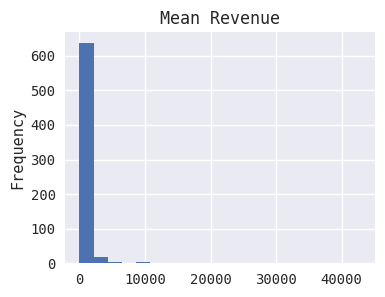

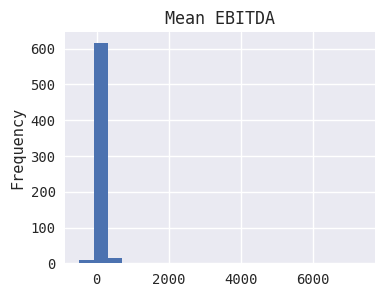

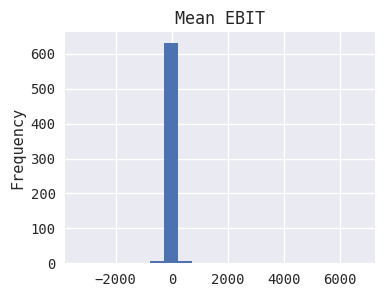

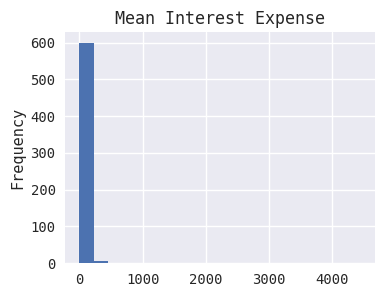

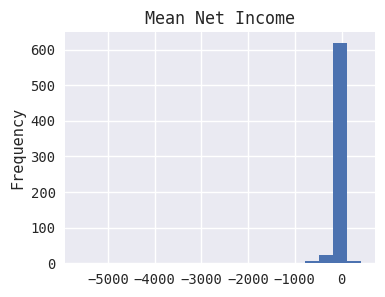

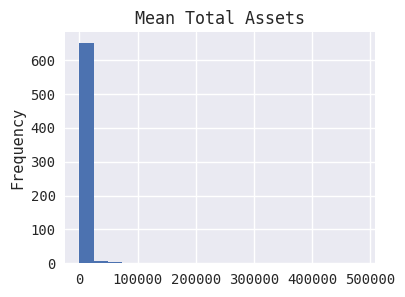

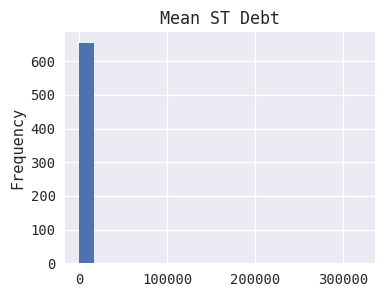

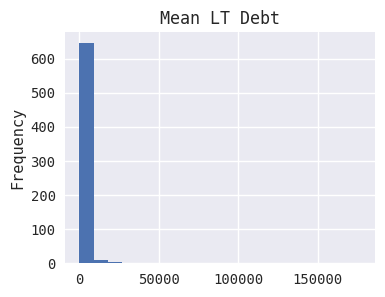

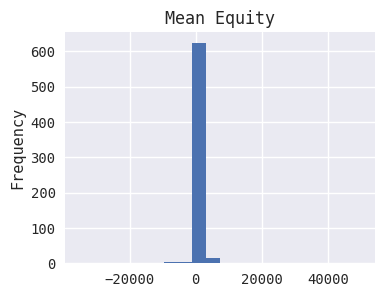

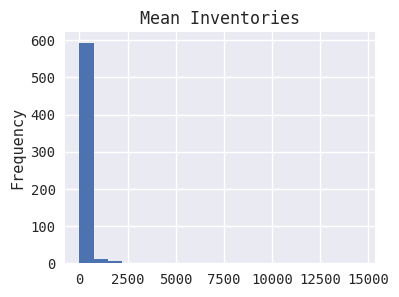

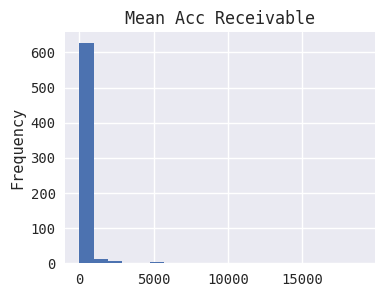

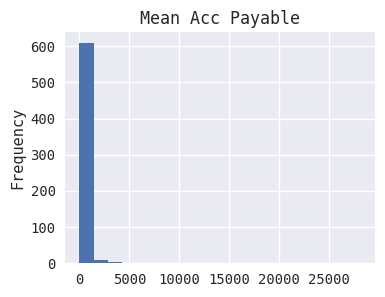

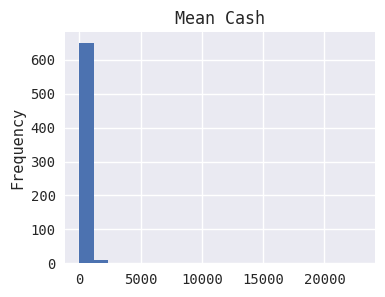

In [22]:
# --- Metric histograms ---

for k, v in wide_sheets.items():
    plt.figure(figsize=(4, 3))
    v.mean(axis=1).plot(kind="hist", bins=20, title=f"Mean {k}")

In [23]:
# --- Weird EBIT-EBITDA cases
(narrow_sheets["EBITDA"] - narrow_sheets["EBIT"]).dropna().sort_values().head(10)

Short Ticker  Quarter
1087117D      2012Q3    -2664.032000
LEHMQ         2005Q4     -406.000000
ATPAQ         2011Q4     -231.353000
578903Z       2010Q2     -165.909000
WCOEQ         2001Q4     -145.000000
SITEQ         2002Q4      -49.126007
1235274D      2009Q4      -47.228000
MIRKQ         2003Q1      -40.000000
              2003Q3      -32.000000
578903Z       2008Q2      -23.763000
dtype: float64

## Putting it all together

### One frame

n records = 63744

n any-valid records = 15490
n all-valid records = 11068

  n valid records:
Revenue             15459
EBITDA              14577
EBIT                15071
Interest Expense    12407
Net Income          15370
Total Assets        15268
ST Debt             15000
LT Debt             15243
Equity              15150
Inventories         14105
Acc Receivable      14985
Acc Payable         13852
Cash                15268
dtype: int64

n records = 63744
n records = 63744
null countdowns = 0 / 63744
null countdowns = 0 / 29161
n records = 29161


Bankruptcy Countdown Bankruptcy Quarter BISC Code lvl1  \
Short Ticker Quarter                                                           
ENDPQ        1998Q1                    -98             2022Q3             16   
             1998Q2                    -97             2022Q3             16   
HSTRQ        2000Q3                     -2             2001Q1             11   
             2000Q4                     -1             2001Q1             11   

                         Revenue     EBITDA       EBIT  Interest Expense  \
Short Ticker Quarter                                                       
ENDPQ        1998Q1          NaN        NaN        NaN               NaN   
             1998Q2          NaN        NaN        NaN               NaN   
HSTRQ        2000Q3   130.354996  -3.437000  -7.656000             4.700   
             2000Q4   139.113007 -12.199999 -16.580999             5.296   

                      Net Income  Total Assets  ST Debt     LT Debt  \
Short Ticker Quarter                                                  
ENDPQ        1998Q1          NaN           NaN      NaN         NaN   
             1998Q2          NaN           NaN      NaN         NaN   
HSTRQ        2000Q3       -8.149    394.433014    2.851  122.219002   
             2000Q4      -30.566    362.233002    2.399  120.728996   

                          Equity  Inventories  Acc Receivable  Acc Payable  \
Short Ticker Quarter                                                         
ENDPQ        1998Q1          NaN          NaN             NaN          NaN   
             1998Q2          NaN          NaN             NaN          NaN   
HSTRQ        2000Q3   124.342998   100.280998       35.723000    26.607000   
             2000Q4    93.708998    90.481003       37.813999    28.872999   

                           Cash  
Short Ticker Quarter             
ENDPQ        1998Q1         NaN  
             1998Q2         NaN  
HSTRQ        2000Q3   36.761002  
             2000Q4   42.820000

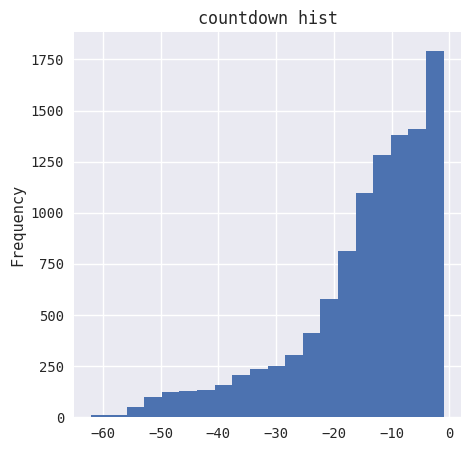

In [24]:
# --- Assemble the frame ---

# Concatenate features
_df = pd.concat(narrow_sheets.values(), axis=1)
print(f"n records = {len(_df)}")

_df = _df.sort_index()
print()
print(f"n any-valid records = {_df.notnull().any(axis=1).sum()}")
print(f"n all-valid records = {_df.notnull().all(axis=1).sum()}")

print("\n  n valid records:")
print(_df.notnull().sum())

# Add bankcruptcy quarter
print()
print(f"n records = {len(_df)}")
_df = pd.merge(
    master_df[[
        "Short Ticker", 
        "Bankruptcy Quarter", 
        # "Bankruptcy Date", 
        "BISC Code lvl1"
    ]],
    _df.reset_index(),
    on=["Short Ticker"],
    how="inner",
)
print(f"n records = {len(_df)}")
_df.insert(
    0, "Bankruptcy Countdown", 
    encode_quarter(_df["Quarter"]) - encode_quarter(_df["Bankruptcy Quarter"])
)
print(f'null countdowns = {_df["Bankruptcy Quarter"].isnull().sum()} / {len(_df)}')

# Filter out records at and after bankruptcy
_df = _df.loc[
    _df["Bankruptcy Countdown"].isnull() | (_df["Bankruptcy Countdown"] < 0)
].reset_index(drop=True)
print(f'null countdowns = {_df["Bankruptcy Quarter"].isnull().sum()} / {len(_df)}')

print(f"n records = {len(_df)}")

_df = _df.set_index(["Short Ticker", "Quarter"])
frame = _df

dht(frame)
_ = frame.dropna()["Bankruptcy Countdown"].plot(kind="hist", bins=20, title="countdown hist")

In [25]:
# --- Check for low metric values ---

for col in ["Revenue", "EBITDA", "Interest Expense"]:
    print(f'zero {col} count = {(frame[col].abs() < 0.0001).sum()}')
    print(f'neg  {col} count = {(frame[col] < -0.0001).sum()}')

zero Revenue count = 0
neg  Revenue count = 23
zero EBITDA count = 1
neg  EBITDA count = 3831
zero Interest Expense count = 347
neg  Interest Expense count = 1


In [26]:
# --- Metric history of a random company --- 

_random_tickers = np.random.choice(frame.reset_index()["Short Ticker"].unique(), size=10, replace=False)
print(_random_tickers)
frame.loc[
    (frame.index.get_level_values(0) == _random_tickers[0])
    & frame["Bankruptcy Countdown"].between(-10, 10)
]

['AAMRQ' 'THVW' 'PBYPQ' '15327Z' 'LECH' 'PROEQ' 'CBKC' 'TDHCE' 'MHRC' 'CSKEQ']


Bankruptcy Countdown Bankruptcy Quarter BISC Code lvl1  \
Short Ticker Quarter                                                           
AAMRQ        2009Q2                    -10             2011Q4             17   
             2009Q3                     -9             2011Q4             17   
             2009Q4                     -8             2011Q4             17   
             2010Q1                     -7             2011Q4             17   
             2010Q2                     -6             2011Q4             17   
             2010Q3                     -5             2011Q4             17   
             2010Q4                     -4             2011Q4             17   
             2011Q1                     -3             2011Q4             17   
             2011Q2                     -2             2011Q4             17   
             2011Q3                     -1             2011Q4             17   

                      Revenue  EBITDA   EBIT  Interest Expense  Net Income  \
Short Ticker Quarter                                                         
AAMRQ        2009Q2    4889.0    56.0 -226.0             157.0      -390.0   
             2009Q3    5127.0    78.0 -194.0             171.0      -359.0   
             2009Q4    5063.0  -112.0 -390.0             198.0      -344.0   
             2010Q1    5068.0   -31.0 -298.0             199.0      -505.0   
             2010Q2    5674.0   463.0  196.0             201.0       -11.0   
             2010Q3    5842.0   616.0  342.0             197.0       143.0   
             2010Q4    5586.0   353.0   68.0             195.0       -97.0   
             2011Q1    5533.0    44.0 -232.0             193.0      -436.0   
             2011Q2    6114.0   188.0  -78.0             205.0      -286.0   
             2011Q3    6376.0   312.0   39.0             200.0      -162.0   

                      Total Assets  ST Debt  LT Debt  Equity  Inventories  \
Short Ticker Quarter                                                        
AAMRQ        2009Q2        24138.0   1228.0   8864.0 -3000.0        535.0   
             2009Q3        25754.0   1132.0  10461.0 -2859.0        546.0   
             2009Q4        25438.0   1114.0  10583.0 -3489.0        557.0   
             2010Q1        25525.0   1140.0  10420.0 -3892.0        552.0   
             2010Q2        25885.0   1829.0   9668.0 -3930.0        569.0   
             2010Q3        25357.0   1776.0   9513.0 -3643.0        575.0   
             2010Q4        25088.0   1883.0   9253.0 -3945.0        594.0   
             2011Q1        27113.0   1962.0  10156.0 -3949.0        595.0   
             2011Q2        25787.0   1830.0  10052.0 -4509.0        641.0   
             2011Q3        24719.0   1453.0  10167.0 -4833.0        631.0   

                      Acc Receivable  Acc Payable   Cash  
Short Ticker Quarter                                      
AAMRQ        2009Q2            780.0       1143.0  191.0  
             2009Q3            814.0       1081.0  171.0  
             2009Q4            768.0       1064.0  153.0  
             2010Q1            842.0       1140.0  189.0  
             2010Q2            910.0       1305.0  197.0  
             2010Q3            889.0       1220.0  202.0  
             2010Q4            738.0       1156.0  168.0  
             2011Q1            922.0       1267.0  286.0  
             2011Q2            945.0       1291.0  318.0  
             2011Q3            925.0       1150.0  304.0

In [27]:
# --- Features ---

frame["Net Profitability"] = frame["Net Income"] / frame["Revenue"]
frame["Operating Profitability"] = frame["EBIT"] / frame["Revenue"]
frame["Equity Ratio"] = frame["Equity"] / frame["Total Assets"]
frame["Net Leverage"] = (
    (frame["ST Debt"] + frame["LT Debt"] - frame["Acc Payable"] - frame["Cash"]) / frame["EBITDA"]
)
frame["Cost of Debt"] = (
    frame["Interest Expense"] / (frame["ST Debt"] + frame["LT Debt"] - frame["Acc Payable"])
)

frame["ICR"] = frame["EBIT"] / frame["Interest Expense"]

frame["Inventory Ratio"] = frame["Inventories"] / frame["Revenue"]
frame["Receivables Ratio"] = frame["Acc Receivable"] / frame["Revenue"]

dht(frame)

Bankruptcy Countdown Bankruptcy Quarter BISC Code lvl1  \
Short Ticker Quarter                                                           
ENDPQ        1998Q1                    -98             2022Q3             16   
             1998Q2                    -97             2022Q3             16   
HSTRQ        2000Q3                     -2             2001Q1             11   
             2000Q4                     -1             2001Q1             11   

                         Revenue     EBITDA       EBIT  Interest Expense  \
Short Ticker Quarter                                                       
ENDPQ        1998Q1          NaN        NaN        NaN               NaN   
             1998Q2          NaN        NaN        NaN               NaN   
HSTRQ        2000Q3   130.354996  -3.437000  -7.656000             4.700   
             2000Q4   139.113007 -12.199999 -16.580999             5.296   

                      Net Income  Total Assets  ST Debt     LT Debt  \
Short Ticker Quarter                                                  
ENDPQ        1998Q1          NaN           NaN      NaN         NaN   
             1998Q2          NaN           NaN      NaN         NaN   
HSTRQ        2000Q3       -8.149    394.433014    2.851  122.219002   
             2000Q4      -30.566    362.233002    2.399  120.728996   

                          Equity  Inventories  Acc Receivable  Acc Payable  \
Short Ticker Quarter                                                         
ENDPQ        1998Q1          NaN          NaN             NaN          NaN   
             1998Q2          NaN          NaN             NaN          NaN   
HSTRQ        2000Q3   124.342998   100.280998       35.723000    26.607000   
             2000Q4    93.708998    90.481003       37.813999    28.872999   

                           Cash  Net Profitability  Operating Profitability  \
Short Ticker Quarter                                                          
ENDPQ        1998Q1         NaN                NaN                      NaN   
             1998Q2         NaN                NaN                      NaN   
HSTRQ        2000Q3   36.761002          -0.062514                -0.058732   
             2000Q4   42.820000          -0.219721                -0.119191   

                      Equity Ratio  Net Leverage  Cost of Debt       ICR  \
Short Ticker Quarter                                                       
ENDPQ        1998Q1            NaN           NaN           NaN       NaN   
             1998Q2            NaN           NaN           NaN       NaN   
HSTRQ        2000Q3       0.315245    -17.952283      0.047734 -1.628936   
             2000Q4       0.258698     -4.215984      0.056188 -3.130853   

                      Inventory Ratio  Receivables Ratio  
Short Ticker Quarter                                      
ENDPQ        1998Q1               NaN                NaN  
             1998Q2               NaN                NaN  
HSTRQ        2000Q3          0.769292           0.274044  
             2000Q4          0.650414           0.271822

In [28]:
# --- Remove infinite values ---

display(frame.describe())
frame.replace([np.inf, -np.inf], np.nan, inplace=True)
display(frame.describe())

,Bankruptcy Countdown,Revenue,EBITDA,EBIT,Interest Expense,Net Income,Total Assets,ST Debt,LT Debt,Equity,Inventories,Acc Receivable,Acc Payable,Cash,Net Profitability,Operating Profitability,Equity Ratio,Net Leverage,Cost of Debt,ICR,Inventory Ratio,Receivables Ratio
count,29161.000000,14606.000000,13779.000000,14238.000000,11726.000000,14522.000000,14438.000000,14185.000000,14415.000000,14328.000000,13315.000000,14161.000000,13080.000000,14438.000000,14514.000000,14232.000000,14327.000000,1.255300e+04,1.102500e+04,1.163800e+04,13291.000000,14134.000000
mean,-30.591852,521.451264,50.846672,5.483128,29.047770,-47.043912,4510.231903,689.326416,1628.163249,645.532425,198.519201,223.888630,211.276765,177.024343,-2.278935,-1.579572,0.114754,inf,inf,NaN,0.439498,0.735195
std,22.769208,2119.487904,466.390321,440.373869,151.002332,508.723607,25175.544481,11990.417386,8059.619331,3251.860959,847.802361,1695.327406,1134.675517,944.768408,71.308406,35.672443,1.518398,NaN,NaN,NaN,0.872701,4.510934
min,-98.000000,-613.954000,-10165.000000,-12476.000000,-14.972000,-38963.000000,0.000000,0.000000,0.000000,-90520.000000,0.000000,-0.009437,-0.072346,0.000000,-5987.142857,-2743.380952,-82.576402,-6.887450e+04,-8.013285e+01,-inf,-3.154341,-111.371376
25%,-46.000000,34.316999,-0.469962,-6.115000,1.124000,-21.000000,191.292500,0.077528,19.000000,10.494750,0.000000,8.554000,10.283750,4.000750,-0.267611,-0.119944,0.067819,-1.768102e+00,1.350329e-02,-1.999602e+00,0.000000,0.235105
50%,-25.000000,124.246500,11.007000,1.625000,7.016500,-1.947500,780.190515,6.500000,261.785004,132.666497,17.642000,43.461000,36.936000,22.427320,-0.029991,0.020422,0.264074,7.213841e+00,2.179630e-02,4.399029e-01,0.223045,0.486024
75%,-11.000000,363.291000,53.652499,22.895250,22.720000,5.668750,2555.226750,54.345001,1088.541504,578.034002,119.815000,164.516998,118.224998,99.504501,0.035985,0.111531,0.455506,2.029438e+01,3.089654e-02,2.363266e+00,0.629832,0.718312
max,-1.000000,53899.000000,15340.775000,11946.000000,6121.997000,7177.227000,786035.000000,519658.000000,286088.000000,58771.000000,17744.000000,188264.000000,30742.000000,34868.000000,516.499972,12.367188,1.318403,inf,inf,inf,34.710000,341.420587


,Bankruptcy Countdown,Revenue,EBITDA,EBIT,Interest Expense,Net Income,Total Assets,ST Debt,LT Debt,Equity,Inventories,Acc Receivable,Acc Payable,Cash,Net Profitability,Operating Profitability,Equity Ratio,Net Leverage,Cost of Debt,ICR,Inventory Ratio,Receivables Ratio
count,29161.000000,14606.000000,13779.000000,14238.000000,11726.000000,14522.000000,14438.000000,14185.000000,14415.000000,14328.000000,13315.000000,14161.000000,13080.000000,14438.000000,14514.000000,14232.000000,14327.000000,12552.000000,11024.000000,1.129200e+04,13291.000000,14134.000000
mean,-30.591852,521.451264,50.846672,5.483128,29.047770,-47.043912,4510.231903,689.326416,1628.163249,645.532425,198.519201,223.888630,211.276765,177.024343,-2.278935,-1.579572,0.114754,-0.079756,0.051252,1.668866e+02,0.439498,0.735195
std,22.769208,2119.487904,466.390321,440.373869,151.002332,508.723607,25175.544481,11990.417386,8059.619331,3251.860959,847.802361,1695.327406,1134.675517,944.768408,71.308406,35.672443,1.518398,1092.949562,6.561752,1.795387e+04,0.872701,4.510934
min,-98.000000,-613.954000,-10165.000000,-12476.000000,-14.972000,-38963.000000,0.000000,0.000000,0.000000,-90520.000000,0.000000,-0.009437,-0.072346,0.000000,-5987.142857,-2743.380952,-82.576402,-68874.500000,-80.132849,-1.455600e+04,-3.154341,-111.371376
25%,-46.000000,34.316999,-0.469962,-6.115000,1.124000,-21.000000,191.292500,0.077528,19.000000,10.494750,0.000000,8.554000,10.283750,4.000750,-0.267611,-0.119944,0.067819,-1.769149,0.013502,-1.738281e+00,0.000000,0.235105
50%,-25.000000,124.246500,11.007000,1.625000,7.016500,-1.947500,780.190515,6.500000,261.785004,132.666497,17.642000,43.461000,36.936000,22.427320,-0.029991,0.020422,0.264074,7.213479,0.021796,4.692870e-01,0.223045,0.486024
75%,-11.000000,363.291000,53.652499,22.895250,22.720000,5.668750,2555.226750,54.345001,1088.541504,578.034002,119.815000,164.516998,118.224998,99.504501,0.035985,0.111531,0.455506,20.290289,0.030893,2.345331e+00,0.629832,0.718312
max,-1.000000,53899.000000,15340.775000,11946.000000,6121.997000,7177.227000,786035.000000,519658.000000,286088.000000,58771.000000,17744.000000,188264.000000,30742.000000,34868.000000,516.499972,12.367188,1.318403,42229.322985,675.512151,1.907495e+06,34.710000,341.420587


In [29]:
frame.notnull().sum()

Bankruptcy Countdown       29161
Bankruptcy Quarter         29161
BISC Code lvl1             29161
Revenue                    14606
EBITDA                     13779
EBIT                       14238
Interest Expense           11726
Net Income                 14522
Total Assets               14438
ST Debt                    14185
LT Debt                    14415
Equity                     14328
Inventories                13315
Acc Receivable             14161
Acc Payable                13080
Cash                       14438
Net Profitability          14514
Operating Profitability    14232
Equity Ratio               14327
Net Leverage               12552
Cost of Debt               11024
ICR                        11292
Inventory Ratio            13291
Receivables Ratio          14134
dtype: int64

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


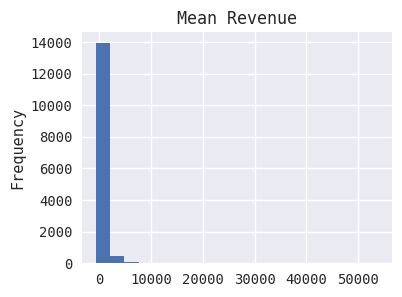

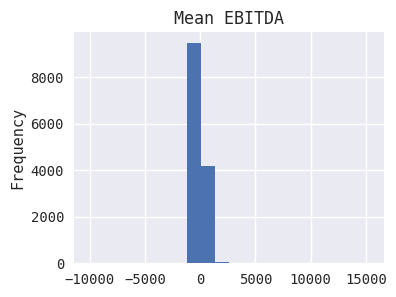

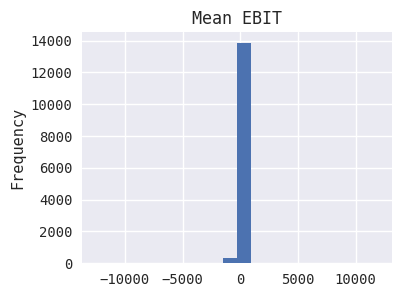

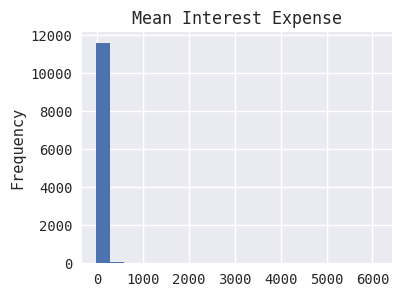

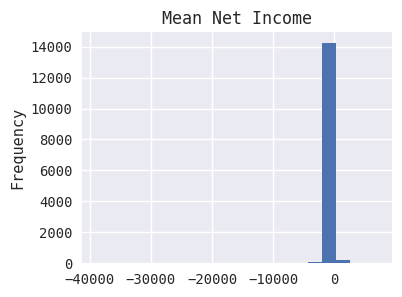

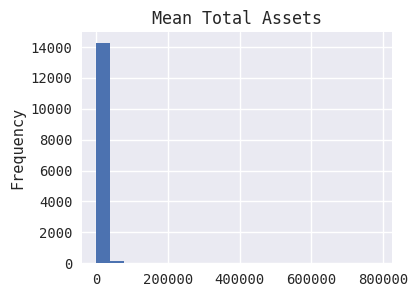

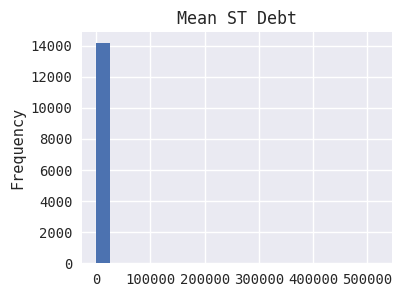

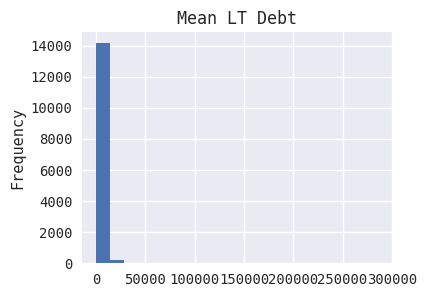

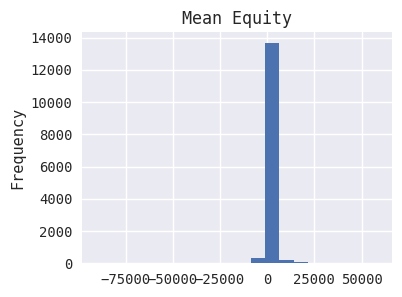

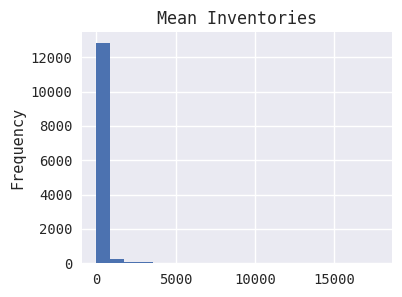

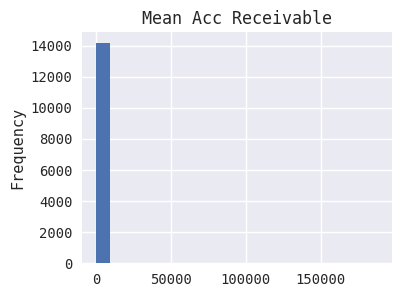

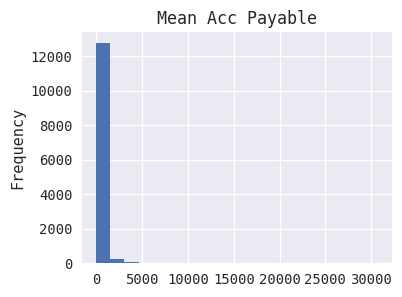

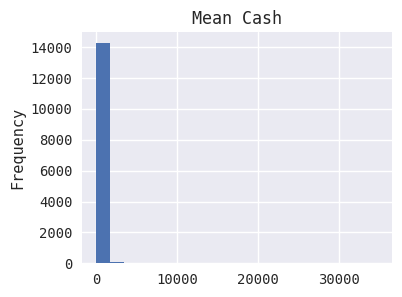

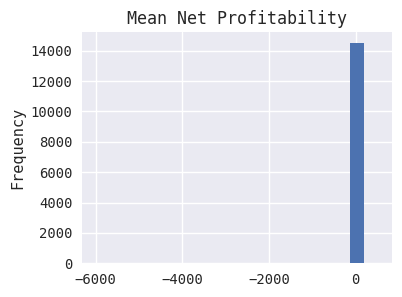

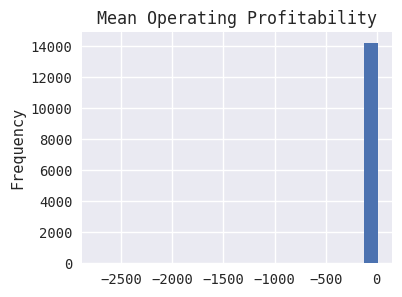

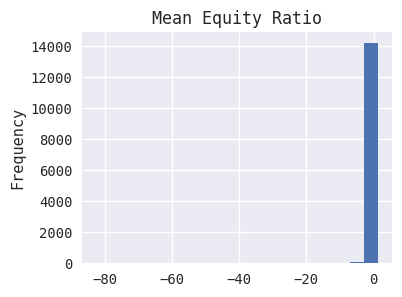

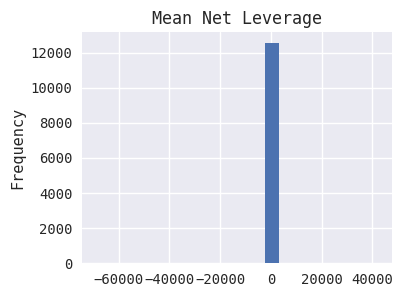

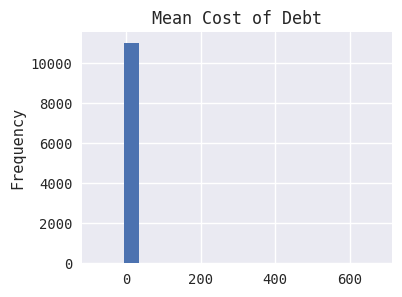

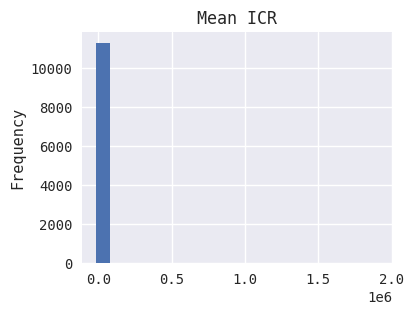

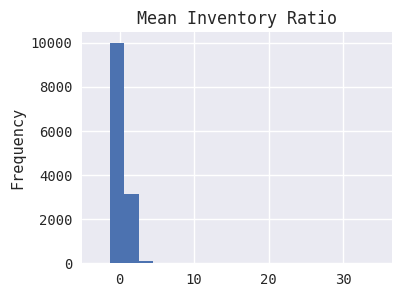

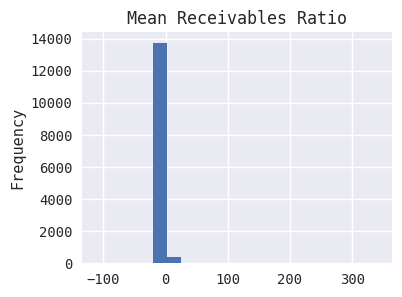

In [30]:
# --- Feature histograms ---
for col in frame.drop(columns=["Bankruptcy Countdown", "Bankruptcy Quarter", "BISC Code lvl1"]).columns:
    plt.figure(figsize=(4, 3))
    frame[col].dropna().plot(kind="hist", bins=20, title=f"Mean {col}")

### More features

In [31]:
dht(frame, 1)

,,Bankruptcy Countdown,Bankruptcy Quarter,BISC Code lvl1,Revenue,EBITDA,EBIT,Interest Expense,Net Income,Total Assets,ST Debt,LT Debt,Equity,Inventories,Acc Receivable,Acc Payable,Cash,Net Profitability,Operating Profitability,Equity Ratio,Net Leverage,Cost of Debt,ICR,Inventory Ratio,Receivables Ratio
Short Ticker,Quarter,,,,,,,,,,,,,,,,,,,,,,,,
ENDPQ,1998Q1,-98,2022Q3,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HSTRQ,2000Q4,-1,2001Q1,11,139.113007,-12.199999,-16.580999,5.296,-30.566,362.233002,2.399,120.728996,93.708998,90.481003,37.813999,28.872999,42.82,-0.219721,-0.119191,0.258698,-4.215984,0.056188,-3.130853,0.650414,0.271822


In [32]:
# --- Time-related features ---

frame["Season"] = frame.index.get_level_values(1).str[-1].astype(int)

In [33]:
# - Shift a quarter back

# _df = frame.groupby("Short Ticker").shift(1)
# _df.columns = [f"{c} P1Q" for c in _df.columns]
# _df.loc["WNDXQ"]

# frame_ = pd.concat([frame, _df], axis=1)
# dht(frame_)

# print(frame_.loc["WNDXQ"].dropna(how="all"))

In [34]:
# TO DO: add more features

### Train and test sets

In [35]:
# --- Count valid samples ---

print(list(frame.columns))
dht(frame, 1)
_df = frame
print("all:")
print(f"n records = {len(_df)}")
print(f"n tickers = {_df.index.get_level_values(0).nunique()}")
_df = frame.dropna(how="all", subset=list(narrow_sheets.keys()))
print("\ndrop rows with all NaNs:")
print(f"n records = {len(_df)}")
print(f"n tickers = {_df.index.get_level_values(0).nunique()}")
_df = frame.dropna(how="any", subset=[x for x in _df.columns if not x.startswith("Bankruptcy ")])
print("\ndrop rows with any NaNs:")
print(f"n records = {len(_df)}")
print(f"n tickers = {_df.index.get_level_values(0).nunique()}")

['Bankruptcy Countdown', 'Bankruptcy Quarter', 'BISC Code lvl1', 'Revenue', 'EBITDA', 'EBIT', 'Interest Expense', 'Net Income', 'Total Assets', 'ST Debt', 'LT Debt', 'Equity', 'Inventories', 'Acc Receivable', 'Acc Payable', 'Cash', 'Net Profitability', 'Operating Profitability', 'Equity Ratio', 'Net Leverage', 'Cost of Debt', 'ICR', 'Inventory Ratio', 'Receivables Ratio', 'Season']


,,Bankruptcy Countdown,Bankruptcy Quarter,BISC Code lvl1,Revenue,EBITDA,EBIT,Interest Expense,Net Income,Total Assets,ST Debt,LT Debt,Equity,Inventories,Acc Receivable,Acc Payable,Cash,Net Profitability,Operating Profitability,Equity Ratio,Net Leverage,Cost of Debt,ICR,Inventory Ratio,Receivables Ratio,Season
Short Ticker,Quarter,,,,,,,,,,,,,,,,,,,,,,,,,
ENDPQ,1998Q1,-98,2022Q3,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
HSTRQ,2000Q4,-1,2001Q1,11,139.113007,-12.199999,-16.580999,5.296,-30.566,362.233002,2.399,120.728996,93.708998,90.481003,37.813999,28.872999,42.82,-0.219721,-0.119191,0.258698,-4.215984,0.056188,-3.130853,0.650414,0.271822,4


all:
n records = 29161
n tickers = 664

drop rows with all NaNs:
n records = 14636
n tickers = 664

drop rows with any NaNs:
n records = 10174
n tickers = 569


In [36]:
# --- Dividing tickers on train and test (by their bankruptcy quarter)

cutoff_quarter = "2016Q1"

frame_ = frame.dropna(how="any", subset=[x for x in _df.columns if not x.startswith("Bankruptcy ")])

# Bankcruptcy tickers
bankruptcy_quarters = (
    frame_.groupby("Short Ticker")["Bankruptcy Quarter"].last()
    .value_counts(sort=False).sort_index()
)
print(f"n companies overall = {bankruptcy_quarters.sum()}")
print(f"n companies recent = {bankruptcy_quarters[cutoff_quarter:].sum()}")

_b_train_tickers = set(
    frame_.loc[frame_["Bankruptcy Quarter"] < cutoff_quarter].index.get_level_values(0)
)
_b_test_tickers = set(
    frame_.loc[frame_["Bankruptcy Quarter"] >= cutoff_quarter].index.get_level_values(0)
)
print()
print(f"n bankcrupt train tickers = {len(_b_train_tickers)}")
print(f"n bankcrupt test tickers = {len(_b_test_tickers)}")

# Control tickers
_c_train_test_tickers = (
    frame_.loc[frame_["Bankruptcy Quarter"].isnull()].index.get_level_values(0).unique().values
)
np.random.shuffle(_c_train_test_tickers)
_n_c_train_tickers = int(
    len(_c_train_test_tickers) * len(_b_train_tickers) / (len(_b_train_tickers) + len(_b_test_tickers))
)
_c_train_tickers = set(_c_train_test_tickers[:_n_c_train_tickers])
_c_test_tickers = set(_c_train_test_tickers[_n_c_train_tickers:])
print(f"n control train tickers = {len(_c_train_tickers)}")
print(f"n control test tickers = {len(_c_test_tickers)}")

# Combined
train_tickers = _b_train_tickers | _c_train_tickers
test_tickers = _b_test_tickers | _c_test_tickers
print()
print(f"n train tickers = {len(train_tickers)}")
print(f"n test tickers = {len(test_tickers)}")

n companies overall = 569
n companies recent = 135

n bankcrupt train tickers = 434
n bankcrupt test tickers = 135
n control train tickers = 0
n control test tickers = 0

n train tickers = 434
n test tickers = 135


In [37]:
# --- Train and test datasets ---

frame_train = frame_.loc[
    frame_.index.get_level_values(0).isin(train_tickers)
    & (frame_.index.get_level_values(1) < cutoff_quarter)
].copy()
print(f'train: {frame_train["Bankruptcy Quarter"].dropna().min()}..{frame_train["Bankruptcy Quarter"].dropna().max()}')
X_train = frame_train.drop(columns=["Bankruptcy Quarter", "Bankruptcy Countdown"]).copy()
y_train = frame_train["Bankruptcy Countdown"].copy()
print(
    f"n pos train samples = {(y_train == -1).sum()} / {len(y_train)}"
    f" ({(y_train == -1).sum() / len(y_train):.3f})"
)

frame_test = frame_.loc[
    frame_.index.get_level_values(0).isin(test_tickers)
    # & (frame_.index.get_level_values(1) > cutoff_quarter)
].copy()
print(f'test: {frame_test["Bankruptcy Quarter"].dropna().min()}..{frame_test["Bankruptcy Quarter"].dropna().max()}')
X_test = frame_test.drop(columns=["Bankruptcy Quarter", "Bankruptcy Countdown"]).copy()
y_test = frame_test["Bankruptcy Countdown"].copy()
print(
    f"n pos test samples = {(y_test == -1).sum()} / {len(y_test)}"
    f" ({(y_test == -1).sum() / len(y_test):.3f})"
)

train: 2001Q1..2015Q4
n pos train samples = 286 / 6320 (0.045)
test: 2016Q1..2022Q3
n pos test samples = 86 / 3854 (0.022)


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


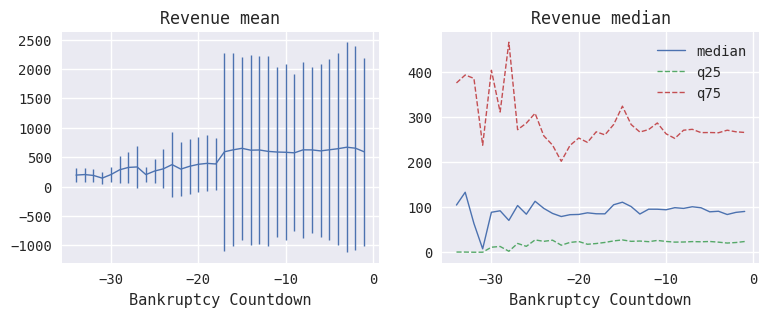

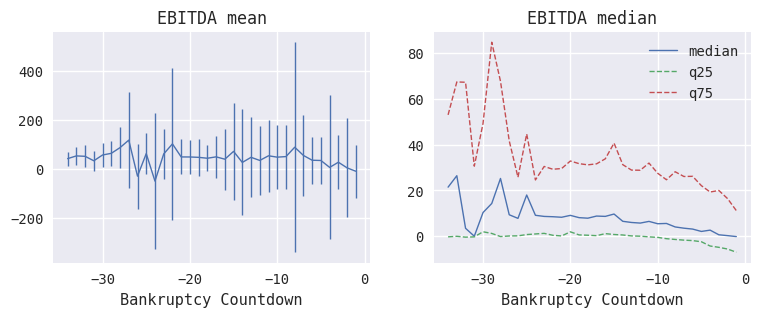

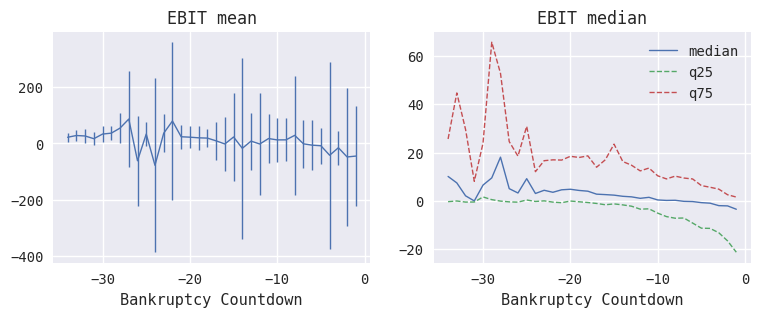

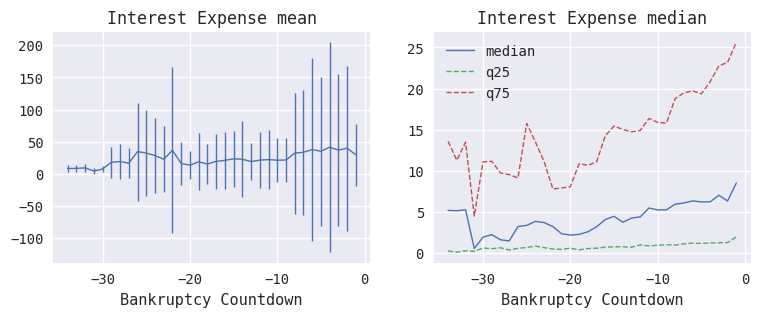

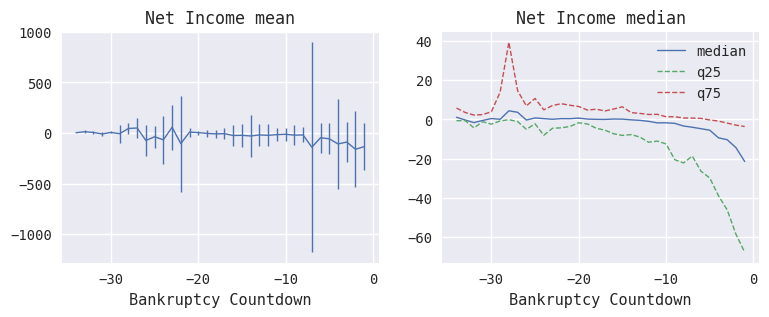

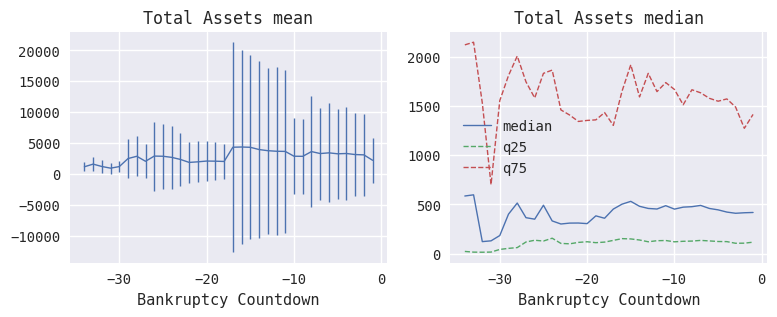

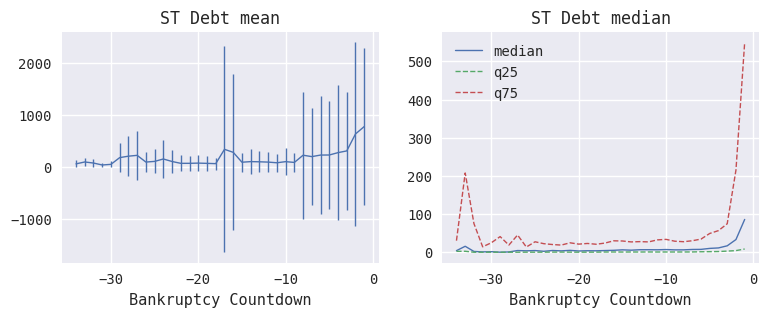

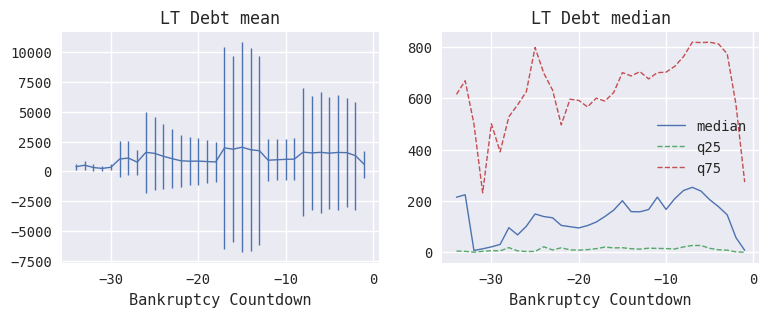

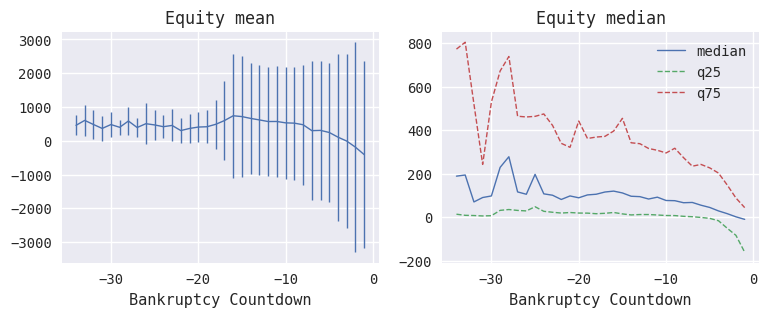

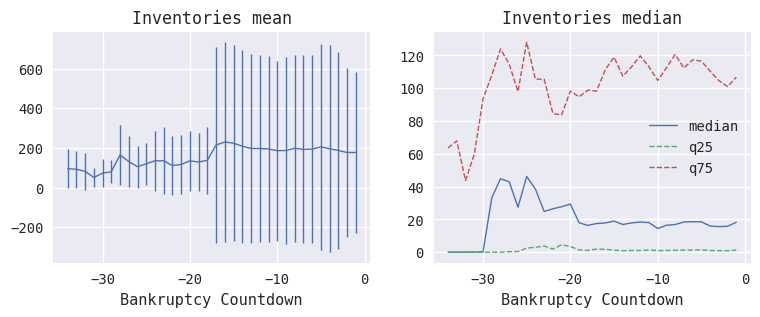

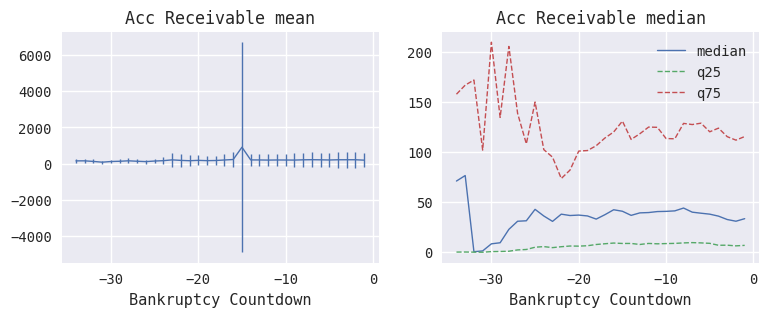

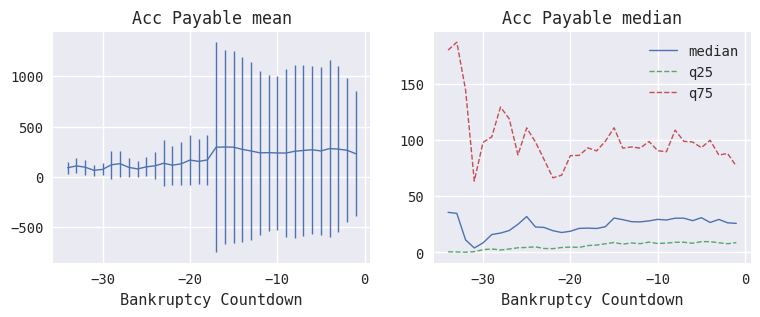

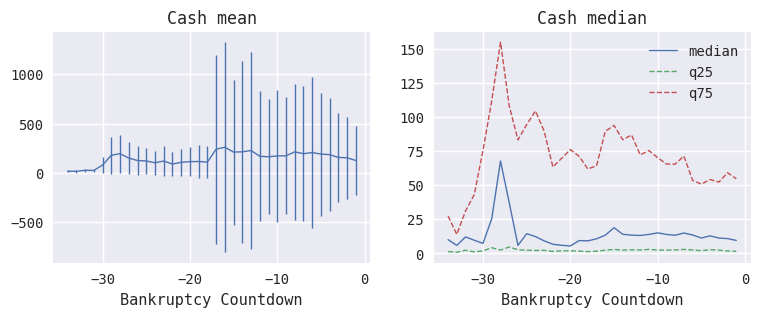

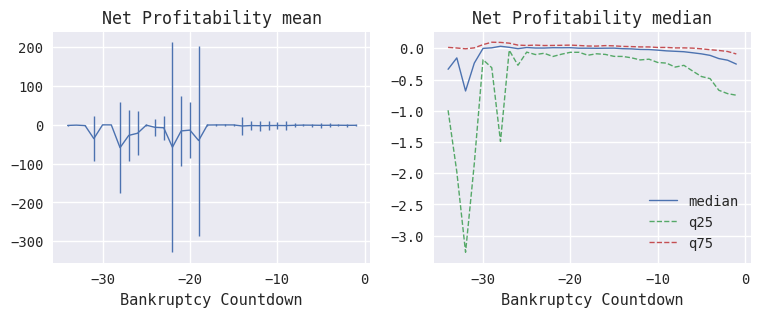

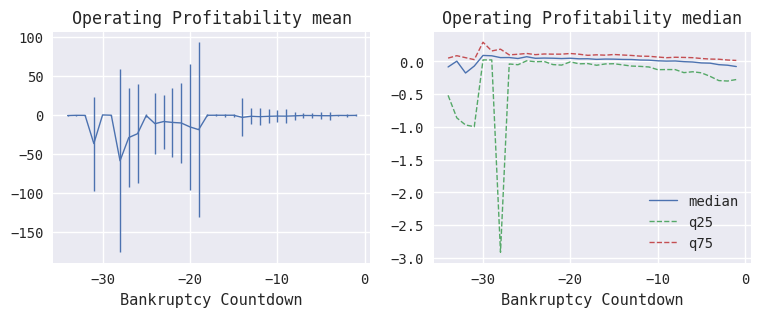

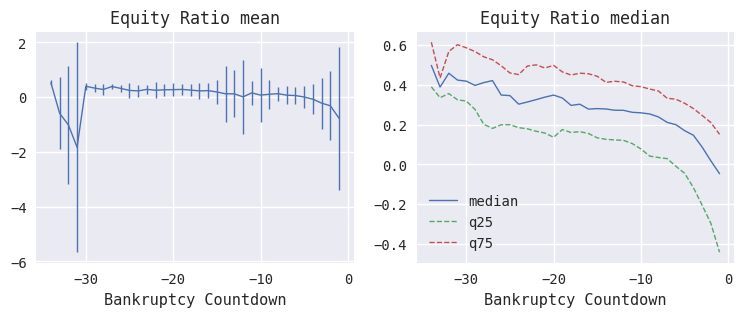

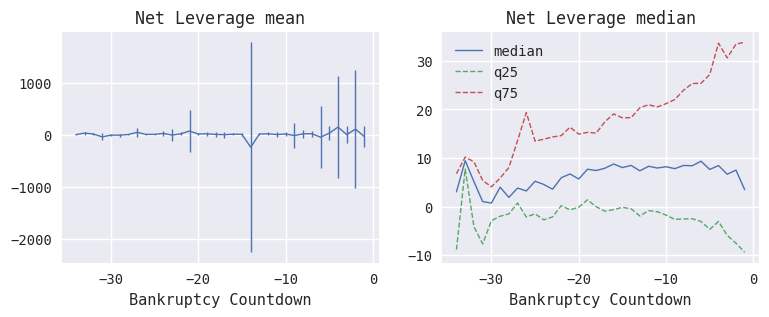

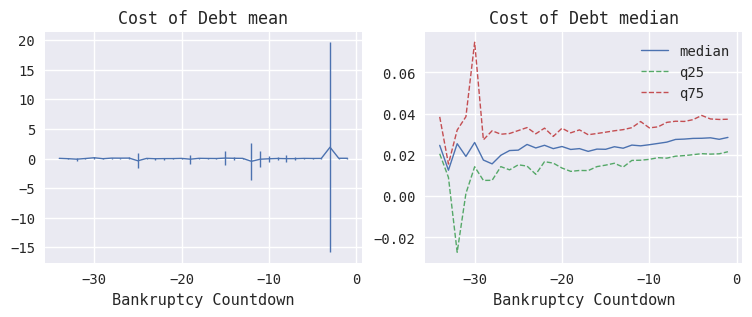

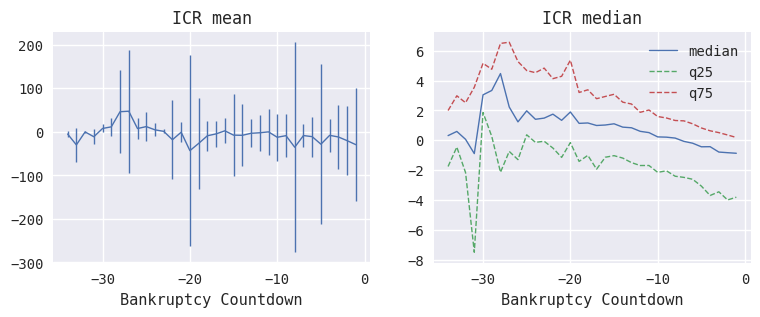

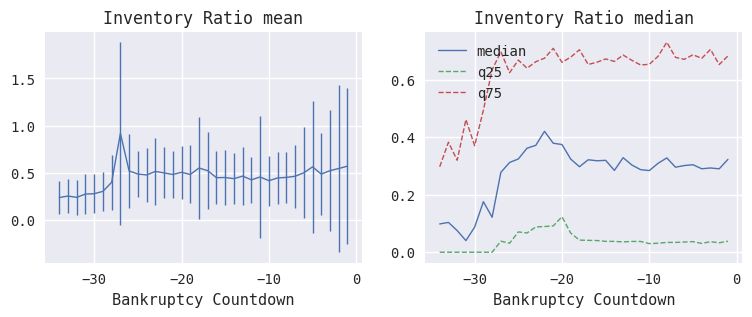

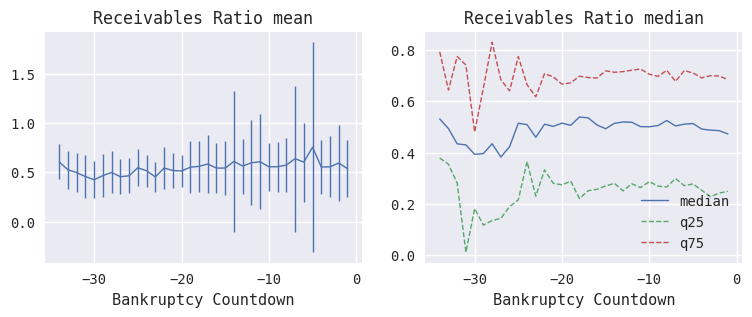

In [38]:
# --- Plotting dependencies ---

for col in X_train.drop(columns=["BISC Code lvl1", "Season"]).columns:
    fig, ax = plt.subplots(1, 2, figsize=(9, 3))
    _agg = frame_train.groupby("Bankruptcy Countdown")[col].agg(
        ["mean", "median", "std", q25, q75, "count"]
    )
    _agg = _agg.loc[_agg["count"] > 5]
    _agg["mean"].plot(title=f"{col} mean", ax=ax[0], yerr=_agg["std"] / 2)
    _agg[["median"]].plot(title=f"{col} median", ax=ax[1])
    _agg[["q25", "q75"]].plot(ax=ax[1], linestyle="--")
_ = _

## Hypothesis 0: We can predict bankcruptcy in the next quarter

- 1 = Bankruptcy next quarter
- 0 = Okay next quarter

In [39]:
def classification_results(
    y_train_, y_test, y_train_hat, y_test_hat, p_train_hat=None, p_test_hat=None,
):
    # mean of sensitivity (TPR) and specificity (TNR)
    print(f"b acc train = {balanced_accuracy_score(y_train_.values, y_train_hat):.2}")
    print(f"b acc test  = {balanced_accuracy_score(y_test_.values, y_test_hat):.2}")
    
    # precision and recall (TPR)
    print()
    print(f"precision train = {precision_score(y_train_.values, y_train_hat):.2}")
    print(f"precision test  = {precision_score(y_test_.values, y_test_hat):.2}")
    print(f"recall train = {recall_score(y_train_.values, y_train_hat):.2}")
    print(f"recall test  = {recall_score(y_test_.values, y_test_hat):.2}")

    # confusion matrix
    print(f"\nconfusion train:")
    print(confusion_matrix(y_train_.values, y_train_hat))
    print(f"\nconfusion test:")
    print(confusion_matrix(y_test_.values, y_test_hat))
    
    # ROC curve plot
    if (p_train_hat is not None) and (p_test_hat is not None):
        _ = RocCurveDisplay.from_predictions(y_train_.values, p_train_hat)


### Logistic regression

In [40]:
def preprocess_X(X):
    return X.drop(columns=["BISC Code lvl1", "Season"])


def preprocess_y(y):
    return (y.replace(pd.NA, -100) == -1).astype(int)

b acc train = 0.52
b acc test  = 0.52

precision train = 0.56
precision test  = 0.75
recall train = 0.031
recall test  = 0.035

confusion train:
[[6027    7]
 [ 277    9]]

confusion test:
[[3767    1]
 [  83    3]]



intercept                 -3.36
LT Debt                   -1.58
ST Debt                    1.13
Operating Profitability    1.07
EBIT                       0.80
Cash                      -0.79
Total Assets              -0.71
EBITDA                    -0.70
Equity                    -0.54
Revenue                    0.43
dtype: float64

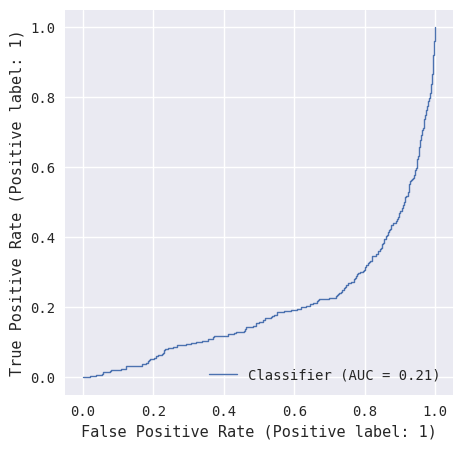

In [41]:
# --- Logistic: No weights ---

X_train_ = preprocess_X(X_train)
y_train_ = preprocess_y(y_train)
X_test_ = preprocess_X(X_test)
y_test_ = preprocess_y(y_test)


m = Pipeline((
    ("s", StandardScaler()),
    ("e", LogisticRegression(penalty="l2", class_weight=None)),
))
m.fit(X_train_, y_train_)
y_train_hat = m.predict(X_train_)
p_train_hat = m.predict_proba(X_train_)[:, 0]
y_test_hat = m.predict(X_test_)
p_test_hat = m.predict_proba(X_test_)[:, 0]

classification_results(
    y_train_, y_test, y_train_hat, y_test_hat, p_train_hat, p_test_hat
)

print()
display(pd.Series(
    np.concatenate([m.named_steps["e"].coef_[0], [m.named_steps["e"].intercept_[0]]]).round(2), 
    index=np.concatenate([X_train_.columns, ['intercept']])
).sort_values(key=lambda x: -abs(x)).head(10))

b acc train = 0.73
b acc test  = 0.76

precision train = 0.17
precision test  = 0.14
recall train = 0.59
recall test  = 0.62

confusion train:
[[5225  809]
 [ 117  169]]

confusion test:
[[3434  334]
 [  33   53]]



lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LT Debt                   -3.07
Operating Profitability    2.67
ST Debt                    2.52
Acc Payable               -1.93
EBITDA                    -1.62
Cash                      -1.30
EBIT                       1.26
Net Income                -1.04
Total Assets               0.99
Equity Ratio              -0.97
dtype: float64

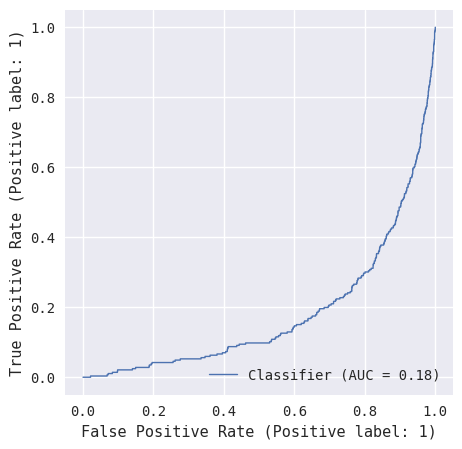

In [42]:
# --- Logistic: Balanced weights ---

X_train_ = preprocess_X(X_train)
y_train_ = preprocess_y(y_train)
X_test_ = preprocess_X(X_test)
y_test_ = preprocess_y(y_test)


m = Pipeline((
    ("s", StandardScaler()),
    ("e", LogisticRegression(penalty="l2", class_weight="balanced")),
))
m.fit(X_train_, y_train_)
y_train_hat = m.predict(X_train_)
p_train_hat = m.predict_proba(X_train_)[:, 0]
y_test_hat = m.predict(X_test_)
p_test_hat = m.predict_proba(X_test_)[:, 0]

classification_results(
    y_train_, y_test, y_train_hat, y_test_hat, p_train_hat, p_test_hat
)

print()
display(pd.Series(
    np.concatenate([m.named_steps["e"].coef_[0], [m.named_steps["e"].intercept_[0]]]).round(2), 
    index=np.concatenate([X_train_.columns, ['intercept']])
).sort_values(key=lambda x: -abs(x)).head(10))

b acc train = 0.72
b acc test  = 0.78

precision train = 0.14
precision test  = 0.12
recall train = 0.62
recall test  = 0.67

confusion train:
[[4984 1050]
 [ 108  178]]

confusion test:
[[3354  414]
 [  28   58]]



Equity Ratio        -0.63
ST Debt              0.50
LT Debt             -0.46
EBITDA              -0.10
intercept           -0.06
Inventory Ratio      0.02
ICR                 -0.01
Receivables Ratio    0.00
Cost of Debt         0.00
Net Leverage         0.00
dtype: float64

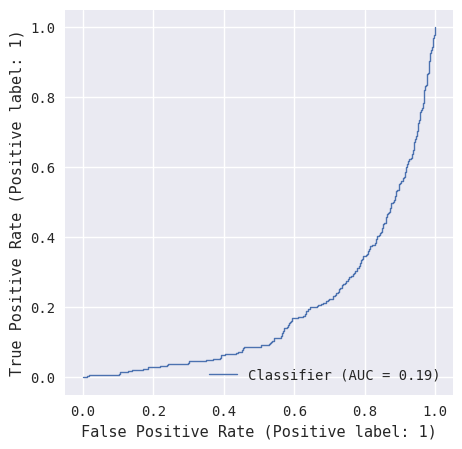

In [50]:
# --- Logistic: Balanced weights + Manual L1 regularization ---

X_train_ = preprocess_X(X_train)
y_train_ = preprocess_y(y_train)
X_test_ = preprocess_X(X_test)
y_test_ = preprocess_y(y_test)


m = Pipeline((
    ("s", StandardScaler()),
    ("e", LogisticRegression(penalty="l1", C=0.01, class_weight="balanced", solver="liblinear")),
))
m.fit(X_train_, y_train_)
y_train_hat = m.predict(X_train_)
p_train_hat = m.predict_proba(X_train_)[:, 0]
y_test_hat = m.predict(X_test_)
p_test_hat = m.predict_proba(X_test_)[:, 0]

classification_results(
    y_train_, y_test, y_train_hat, y_test_hat, p_train_hat, p_test_hat
)

print()
display(pd.Series(
    np.concatenate([m.named_steps["e"].coef_[0], [m.named_steps["e"].intercept_[0]]]).round(2), 
    index=np.concatenate([X_train_.columns, ['intercept']])
).sort_values(key=lambda x: -abs(x)).head(10))

b acc train = 0.72
b acc test  = 0.78

precision train = 0.15
precision test  = 0.12
recall train = 0.62
recall test  = 0.67

confusion train:
[[4985 1049]
 [ 108  178]]

confusion test:
[[3353  415]
 [  28   58]]

LogisticRegression(C=0.01, class_weight='balanced', penalty='l1',
                   solver='liblinear')


Equity Ratio              -0.63
ST Debt                    0.50
LT Debt                   -0.46
EBITDA                    -0.10
intercept                 -0.06
Inventory Ratio            0.02
ICR                       -0.01
Cost of Debt               0.00
Net Leverage               0.00
Operating Profitability    0.00
dtype: float64

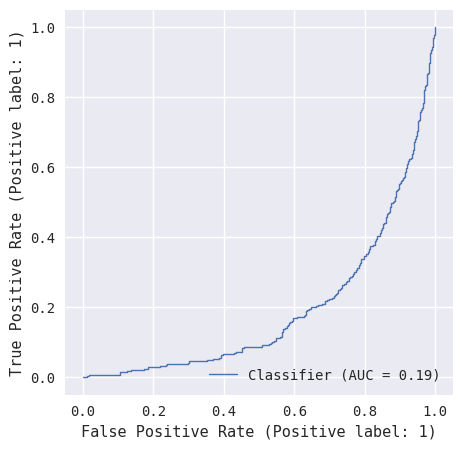

In [44]:
# --- Logistic: Balanced weights + Auto L1 regularization ---

X_train_ = preprocess_X(X_train)
y_train_ = preprocess_y(y_train)
X_test_ = preprocess_X(X_test)
y_test_ = preprocess_y(y_test)


m = GridSearchCV(
    Pipeline((
        ("s", StandardScaler()),
        ("e", LogisticRegression(penalty="l1", class_weight="balanced", solver="liblinear")),
    )),
    {
        'e__C': [0.05, 0.01, 0.2, 0.5, 1.0],
    },
    scoring="balanced_accuracy",
    cv=5,
)
m.fit(X_train_, y_train_)
y_train_hat = m.predict(X_train_)
p_train_hat = m.predict_proba(X_train_)[:, 0]
y_test_hat = m.predict(X_test_)
p_test_hat = m.predict_proba(X_test_)[:, 0]

classification_results(
    y_train_, y_test, y_train_hat, y_test_hat, p_train_hat, p_test_hat
)

print()
best = m.best_estimator_
print(best.named_steps["e"])
display(pd.Series(
    np.concatenate([best.named_steps["e"].coef_[0], [best.named_steps["e"].intercept_[0]]]).round(2), 
    index=np.concatenate([X_train_.columns, ['intercept']])
).sort_values(key=lambda x: -abs(x)).head(10))

### GB Trees

In [45]:
def preprocess_X(X):
    X = X.copy()
    X["BISC Code lvl1"] =  X["BISC Code lvl1"].astype('category')
    X["Season"] =  X["Season"].astype('category')
    return X


def preprocess_y(y):
    return (y.replace(pd.NA, -100) == -1).astype(int)

b acc train = 0.83
b acc test  = 0.82

precision train = 0.19
precision test  = 0.15
recall train = 0.84
recall test  = 0.74

confusion train:
[[5020 1014]
 [  47  239]]

confusion test:
[[3406  362]
 [  22   64]]

LGBMClassifier(class_weight='balanced', min_child_samples=5, num_leaves=3,
               objective='cross_entropy', reg_lambda=0.3)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


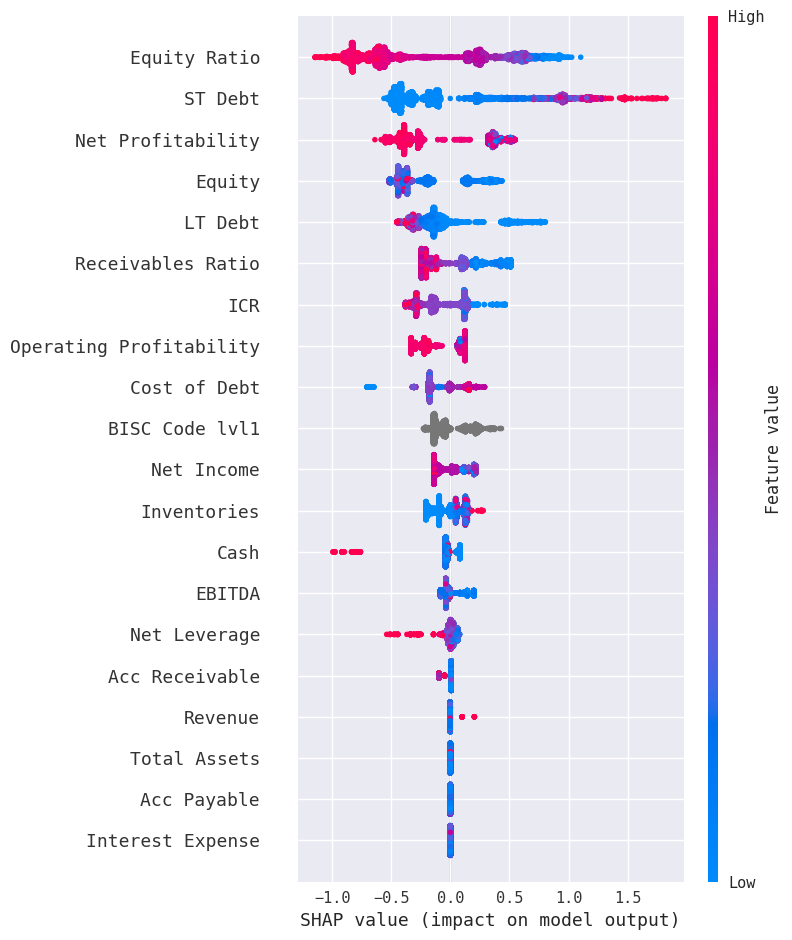

In [46]:
# --- GB Trees: Balanced weights + Auto hyper-parameter tuning ---

X_train_ = preprocess_X(X_train)
y_train_ = preprocess_y(y_train)
X_test_ = preprocess_X(X_test)
y_test_ = preprocess_y(y_test)


m = GridSearchCV(
    LGBMClassifier(
        n_estimators=100, 
        min_child_samples=5,
        objective="cross_entropy",
        class_weight="balanced",
    ),
    {
        'num_leaves': [15, 7, 3],
        'learning_rate': [0.001, 0.003, 0.01, 0.03, 0.1],
        'reg_lambda': [0.003, 0.01, 0.3, 1.],
    },
    scoring="balanced_accuracy",
    cv=5,
)
m.fit(X_train_, y_train_)
y_train_hat = m.predict(X_train_)
y_test_hat = m.predict(X_test_)

classification_results(
    y_train_, y_test, y_train_hat, y_test_hat
)

print()
best = m.best_estimator_
print(best)

# explainer = shap.TreeExplainer(best, X_train_)  # DOES NOT WORK DUE TO A SHAP BUG
explainer = shap.TreeExplainer(best)
shap_values = explainer.shap_values(X_test_, y_test_)
shap.summary_plot(shap_values, X_test_)